# In this model, the additional dataset has been used to create new features and the model is trained using these features.

## 1a. Loading Data and Packages  

In [1]:
!pip install --upgrade pip

Requirement already up-to-date: pip in /home/saritacharde04/anaconda3/lib/python3.6/site-packages (19.2.3)


In [3]:
from category_encoders import OrdinalEncoder, OneHotEncoder
import eli5
#from eli5.sklearn import PermutationImportance

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import randint, uniform

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder as OHE
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from functools import partial
from tqdm import tqdm_notebook as tqdm


In [4]:
from lightgbm import LGBMRegressor
import lightgbm as lgb

In [5]:
trainval = pd.read_csv('../datasets/train/train.csv')
test = pd.read_csv('../datasets/test/test.csv')
structures = pd.read_csv('../datasets/train/structures.csv')
dipole = pd.read_csv('../datasets/train/dipole_moments.csv')
contrib = pd.read_csv('../datasets/train/scalar_coupling_contributions.csv')
magnetic = pd.read_csv('../datasets/train/magnetic_shielding_tensors.csv')
mulliken = pd.read_csv('../datasets/train/mulliken_charges.csv')
potential_energy = pd.read_csv('../datasets/train/potential_energy.csv')


# 1b. Inference of EDA
a. Looking at the data, we can see that the train and test sets had relatively even distributions of scalar coupling type and of the number of atoms present in each dataset. This tells us that the train data is a good enough representation of the test data in order to create a model that predicts the scalar coupling constants. b. The distribution of the scalar coupling constant values isolated by type also reveals that there are clear differences in the ranges that these values appear in. This gives us the insight that different molecular properties affect each type of J coupling differently and unique models should be used for all 8 coupling types found in the dataset. c. The test set structure is the same as the training except that we don't have the scalar_coupling_constant column. Among the other datasets, the most promising seems to be structures.csv, as it is the only one that is available for both training and testing sets. All the other dataframes are available only for the former. d. It is mentioned in the problem statement that the molecules listed for train and test are totally different. e. there are no null values for both train and test

## 2. Reduce Memory Function

In [8]:
def reduce_mem_usage(df, verbose=True):
    """
    This function reduces the numeric to the least possible numeric type that fits the data so 
    memory usage during transforming and training will be reduced.
    Taken from: https://www.kaggle.com/todnewman/keras-neural-net-for-champs
    
    Han
    Parameters:
    ===========
    dataframe: input dataframe 
    verbose: verbose mode, default True.
    Output:
    ===========
    dataframe: dataframe with numeric columns types changed to the least possible size
    """

    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## 3. Create features on structures

In [9]:
!pip install tqdm
from tqdm import tqdm_notebook as tqdm
# get a reliable estimate of how long it will take.
# see immediately if it’s stuck.

# 3a. Bond counts by element
Based on the number of electrons in an atom's valence shell, we know how many bonds the atom needs to form to be stable. Hydrogen needs 1, Flourine needs 1, Oxygen needs 2, Nitrogen needs 3, and Carbon needs 4. Bonds can be single, double, or triple, but we have not yet calculated the strength of the bonds. Therefore there is a range of valid bond counts we could get for each atom.


# 3b. Using the atomic radii, electronegativity values of the atoms (C, H, N, O, F), 
new features like atoms_rad and atoms_en are created. The number of bonds as n_bonds and bond_lengths_mean. This gives a new structutres file.here we create a dictionary of a new column with the new values
then pass the values to the dataframe


# 3c. Fudge factor is to account for unceratainty
the fudge values are added slightly, in order to reduce false negatives. Atoms that are not bonded repel each other, so it should be rare that this increase will result in false positives.


In [10]:
%time
atomic_radius = {'H':0.38, 'C':0.77, 'N':0.75, 'O':0.73, 'F':0.71} # Without fudge factor

fudge_factor = 0.05
atomic_radius = {k:v + fudge_factor for k,v in atomic_radius.items()}
print(atomic_radius)

electronegativity = {'H':2.2, 'C':2.55, 'N':3.04, 'O':3.44, 'F':3.98}

atoms = structures['atom'].values
atoms_en = [electronegativity[x] for x in tqdm(atoms)]
atoms_rad = [atomic_radius[x] for x in tqdm(atoms)]

structures['EN'] = atoms_en
structures['rad'] = atoms_rad

i_atom = structures['atom_index'].values # a list of all 'atom_index' in structures
p = structures[['x', 'y', 'z']].values  # a list of cartesian coordinates (x,y,z) values in structures
p_compare = p
m = structures['molecule_name'].values # a list of molecule name in structures
m_compare = m
r = structures['rad'].values # a list of rad in structures
r_compare = r

source_row = np.arange(len(structures)) # returns an array of evenly spaced values
max_atoms = 28

bonds = np.zeros((len(structures)+1, max_atoms+1), dtype=np.int8)
bond_dists = np.zeros((len(structures)+1, max_atoms+1), dtype=np.float32)

print('Calculating bonds')

for i in tqdm(range(max_atoms-1)):
    p_compare = np.roll(p_compare, -1, axis=0)
    m_compare = np.roll(m_compare, -1, axis=0)
    r_compare = np.roll(r_compare, -1, axis=0)
    
    mask = np.where(m == m_compare, 1, 0) #Are we still comparing atoms in the same molecule? We are trying to compare to 
                                          # to distinguish between two different molecules.
    dists = np.linalg.norm(p - p_compare, axis=1) * mask
    r_bond = r + r_compare
    
    bond = np.where(np.logical_and(dists > 0.0001, dists < r_bond), 1, 0)
    
    source_row = source_row
    target_row = source_row + i + 1 #Note: Will be out of bounds of bonds array for some values of i
    target_row = np.where(np.logical_or(target_row > len(structures), mask==0), len(structures), target_row) #If invalid target, write to dummy row
    
    source_atom = i_atom
    target_atom = i_atom + i + 1 #Note: Will be out of bounds of bonds array for some values of i
    target_atom = np.where(np.logical_or(target_atom > max_atoms, mask==0), max_atoms, target_atom) #If invalid target, write to dummy col
    
    bonds[(source_row, target_atom)] = bond
    bonds[(target_row, source_atom)] = bond
    bond_dists[(source_row, target_atom)] = dists
    bond_dists[(target_row, source_atom)] = dists

bonds = np.delete(bonds, axis=0, obj=-1) #Delete dummy row
bonds = np.delete(bonds, axis=1, obj=-1) #Delete dummy col
bond_dists = np.delete(bond_dists, axis=0, obj=-1) #Delete dummy row
bond_dists = np.delete(bond_dists, axis=1, obj=-1) #Delete dummy col

print('Counting and condensing bonds')

bonds_numeric = [[i for i,x in enumerate(row) if x] for row in tqdm(bonds)]
bond_lengths = [[dist for i,dist in enumerate(row) if i in bonds_numeric[j]] for j,row in enumerate(tqdm(bond_dists))]
bond_lengths_mean = [ np.mean(x) for x in bond_lengths]
n_bonds = [len(x) for x in bonds_numeric]

bond_data = {'n_bonds':n_bonds, 'bond_lengths_mean': bond_lengths_mean }
bond_df = pd.DataFrame(bond_data)
structures = structures.join(bond_df)
display(structures.head(20))


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 13.4 µs
{'H': 0.43, 'C': 0.8200000000000001, 'N': 0.8, 'O': 0.78, 'F': 0.76}


A Jupyter Widget

A Jupyter Widget


Calculating bonds


A Jupyter Widget


Counting and condensing bonds


A Jupyter Widget

A Jupyter Widget

molecule_name  atom_index atom         x         y         z    EN  \
0   dsgdb9nsd_000001           0    C -0.012698  1.085804  0.008001  2.55   
1   dsgdb9nsd_000001           1    H  0.002150 -0.006031  0.001976  2.20   
2   dsgdb9nsd_000001           2    H  1.011731  1.463751  0.000277  2.20   
3   dsgdb9nsd_000001           3    H -0.540815  1.447527 -0.876644  2.20   
4   dsgdb9nsd_000001           4    H -0.523814  1.437933  0.906397  2.20   
5   dsgdb9nsd_000002           0    N -0.040426  1.024108  0.062564  3.04   
6   dsgdb9nsd_000002           1    H  0.017257  0.012545 -0.027377  2.20   
7   dsgdb9nsd_000002           2    H  0.915789  1.358745 -0.028758  2.20   
8   dsgdb9nsd_000002           3    H -0.520278  1.343532 -0.775543  2.20   
9   dsgdb9nsd_000003           0    O -0.034360  0.977540  0.007602  3.44   
10  dsgdb9nsd_000003           1    H  0.064766  0.020572  0.001535  2.20   
11  dsgdb9nsd_000003           2    H  0.871790  1.300792  0.000693  2.20   
12  dsgdb9nsd_000004           0    C  0.599539  0.000000  1.000000  2.55   
13  dsgdb9nsd_000004           1    C -0.599539  0.000000  1.000000  2.55   
14  dsgdb9nsd_000004           2    H -1.661639  0.000000  1.000000  2.20   
15  dsgdb9nsd_000004           3    H  1.661639  0.000000  1.000000  2.20   
16  dsgdb9nsd_000005           0    C -0.013324  1.132466  0.008276  2.55   
17  dsgdb9nsd_000005           1    N  0.002311 -0.019159  0.001929  3.04   
18  dsgdb9nsd_000005           2    H -0.027803  2.198949  0.014154  2.20   
19  dsgdb9nsd_000007           0    C -0.018704  1.525582  0.010433  2.55   

     rad  n_bonds  bond_lengths_mean  
0   0.82        4           1.091950  
1   0.43        1           1.091953  
2   0.43        1           1.091952  
3   0.43        1           1.091946  
4   0.43        1           1.091948  
5   0.80        3           1.017195  
6   0.43        1           1.017190  
7   0.43        1           1.017187  
8   0.43        1           1.017208  
9   0.78        2           0.962107  
10  0.43        1           0.962107  
11  0.43        1           0.962107  
12  0.82        2           1.130589  
13  0.82        2           1.130589  
14  0.43        1           1.062099  
15  0.43        1           1.062099  
16  0.82        2           1.109173  
17  0.80        1           1.151748  
18  0.43        1           1.066598  
19  0.82        4           1.203627

# 4a. Function to merge structures data with train data 

In [11]:
def merge_train_structures(train, structures):
  
  """This function is used to merge the structures dataset to the 
     original train dataset
     
     Parameters:
     ===========
	   train: train dataframe
	   structures: structures dataframe.
     
     Output:
	   ===========
	   dataframe: merged dataframe
     """
  
  structures = structures.rename({'atom_index': 'atom_index_0',
                                  'x':'x_0', 'y':'y_0', 'z':'z_0',
                                  'atom':'atom_0'}, axis=1)
  
  merged = pd.merge(train, structures, on=['molecule_name', 'atom_index_0'])
  
  structures = structures.rename({'atom_index_0': 'atom_index_1',
                                  'x_0':'x_1', 'y_0':'y_1', 'z_0':'z_1',
                                  'atom_0':'atom_1'}, axis=1)
  
  merged_1 = pd.merge(merged, structures, on=['molecule_name', 'atom_index_1'])
  
  structures = structures.rename({'atom_index_1': 'atom_index',
                                  'x_1':'x', 'y_1':'y', 'z_1':'z',
                                  'atom_1':'atom'}, axis=1)
  
  assert train.shape[0] == merged.shape[0]
  
  return merged_1

In [12]:
merged = merge_train_structures(trainval, structures)

In [13]:
merged.head(1)


id     molecule_name  atom_index_0  atom_index_1  type  \
0   0  dsgdb9nsd_000001             1             0  1JHC   

   scalar_coupling_constant atom_0      x_0       y_0       z_0  ...  \
0                   84.8076      H  0.00215 -0.006031  0.001976  ...   

   n_bonds_x  bond_lengths_mean_x  atom_1       x_1       y_1       z_1  EN_y  \
0          1             1.091953       C -0.012698  1.085804  0.008001  2.55   

   rad_y  n_bonds_y  bond_lengths_mean_y  
0   0.82          4              1.09195  

[1 rows x 22 columns]

In [14]:
merged.shape

(4658147, 22)

In [15]:
assert len(merged) == len(trainval)
merged.head()

id     molecule_name  atom_index_0  atom_index_1  type  \
0   0  dsgdb9nsd_000001             1             0  1JHC   
1   4  dsgdb9nsd_000001             2             0  1JHC   
2   7  dsgdb9nsd_000001             3             0  1JHC   
3   9  dsgdb9nsd_000001             4             0  1JHC   
4   1  dsgdb9nsd_000001             1             2  2JHH   

   scalar_coupling_constant atom_0       x_0       y_0       z_0  ...  \
0                   84.8076      H  0.002150 -0.006031  0.001976  ...   
1                   84.8074      H  1.011731  1.463751  0.000277  ...   
2                   84.8093      H -0.540815  1.447527 -0.876644  ...   
3                   84.8095      H -0.523814  1.437933  0.906397  ...   
4                  -11.2570      H  0.002150 -0.006031  0.001976  ...   

   n_bonds_x  bond_lengths_mean_x  atom_1       x_1       y_1       z_1  EN_y  \
0          1             1.091953       C -0.012698  1.085804  0.008001  2.55   
1          1             1.091952       C -0.012698  1.085804  0.008001  2.55   
2          1             1.091946       C -0.012698  1.085804  0.008001  2.55   
3          1             1.091948       C -0.012698  1.085804  0.008001  2.55   
4          1             1.091953       H  1.011731  1.463751  0.000277  2.20   

   rad_y  n_bonds_y  bond_lengths_mean_y  
0   0.82          4             1.091950  
1   0.82          4             1.091950  
2   0.82          4             1.091950  
3   0.82          4             1.091950  
4   0.43          1             1.091952  

[5 rows x 22 columns]

# 4b. Function to merge Mulliken charges with previously merged dataset
Here the number of features have been increased to 24 from 22

In [18]:
mulliken = mulliken.rename({'atom_index': 'atom_index_0',
                          'mulliken_charge': 'mulliken_charge_0'}, axis=1)
merged = merged.merge(mulliken, on=['molecule_name', 'atom_index_0'])

mulliken = mulliken.rename({'atom_index_0': 'atom_index_1',
                          'mulliken_charge_0': 'mulliken_charge_1'}, axis=1)
merged = merged.merge(mulliken, on=['molecule_name', 'atom_index_1'])
assert len(merged) == len(trainval)

In [20]:
merged.head(1)

id     molecule_name  atom_index_0  atom_index_1  type  \
0   0  dsgdb9nsd_000001             1             0  1JHC   

   scalar_coupling_constant atom_0      x_0       y_0       z_0  ...  atom_1  \
0                   84.8076      H  0.00215 -0.006031  0.001976  ...       C   

        x_1       y_1       z_1  EN_y  rad_y  n_bonds_y  bond_lengths_mean_y  \
0 -0.012698  1.085804  0.008001  2.55   0.82          4              1.09195   

   mulliken_charge_0  mulliken_charge_1  
0           0.133921          -0.535689  

[1 rows x 24 columns]

In [21]:
merged.shape

(4658147, 24)

## 4c. Creating features
1. distance — the distance between the given cartesian points of each atom
2. n_bonds — the number of bonds on a specific atom
3. mu — the square root of the sum of the squared Cartesian values
4. delta_en — the difference between the electronegativities of two atoms
5. Advanced features were created with the help of a few helpful Kaggle kernels

In [23]:
%%time
# This block is creating distance 'dist' feature using the linalg and merging with the 'merged' file.

train_p_0 = merged[['x_0', 'y_0', 'z_0']].values
train_p_1 = merged[['x_1', 'y_1', 'z_1']].values

merged['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)

assert len(merged) == len(trainval)#assert len means confirming no of items in merged and trainval

CPU times: user 124 ms, sys: 124 ms, total: 248 ms
Wall time: 244 ms


In [24]:
merged.head()

id     molecule_name  atom_index_0  atom_index_1  type  \
0   0  dsgdb9nsd_000001             1             0  1JHC   
1   4  dsgdb9nsd_000001             2             0  1JHC   
2   7  dsgdb9nsd_000001             3             0  1JHC   
3   9  dsgdb9nsd_000001             4             0  1JHC   
4   1  dsgdb9nsd_000001             1             2  2JHH   

   scalar_coupling_constant atom_0       x_0       y_0       z_0  ...  \
0                   84.8076      H  0.002150 -0.006031  0.001976  ...   
1                   84.8074      H  1.011731  1.463751  0.000277  ...   
2                   84.8093      H -0.540815  1.447527 -0.876644  ...   
3                   84.8095      H -0.523814  1.437933  0.906397  ...   
4                  -11.2570      H  0.002150 -0.006031  0.001976  ...   

        x_1       y_1       z_1  EN_y rad_y  n_bonds_y  bond_lengths_mean_y  \
0 -0.012698  1.085804  0.008001  2.55  0.82          4             1.091950   
1 -0.012698  1.085804  0.008001  2.55  0.82          4             1.091950   
2 -0.012698  1.085804  0.008001  2.55  0.82          4             1.091950   
3 -0.012698  1.085804  0.008001  2.55  0.82          4             1.091950   
4  1.011731  1.463751  0.000277  2.20  0.43          1             1.091952   

   mulliken_charge_0  mulliken_charge_1      dist  
0           0.133921          -0.535689  1.091953  
1           0.133922          -0.535689  1.091952  
2           0.133923          -0.535689  1.091946  
3           0.133923          -0.535689  1.091948  
4           0.133921           0.133922  1.783120  

[5 rows x 25 columns]

# 4d. Grouping the data according to the molecule names

The training data includes more than 1 observation under each molecule_name. Because of this nature, we had to be considerate to not leak data from train molecules into the validation set. We did a train_test_split() on the molecule_name instead, and created train/val subsets with the data from each J type — now 16 subsets total!
Creating features like count, mean, min using distance

In [27]:
merged['type'].value_counts()
merged['molecule_couples'] = merged.groupby('molecule_name')['id'].transform('count')

In [28]:
 merged['molecule_dist_mean'] = merged.groupby('molecule_name')['dist'].transform('mean')

In [29]:
 merged['molecule_dist_min'] = merged.groupby('molecule_name')['dist'].transform('min')

In [30]:
external_data_0 = pd.DataFrame(data={
    'atom_0': ['C', 'H', 'N', 'O', 'F'],
    'atom_0_en': [2.55, 2.20, 3.04, 3.44, 3.98],
    'atomic_mass_0': [12.0107, 1.00784, 14.0067, 15.999, 18.9984],
    'valence_electrons_0': [4, 1, 5, 6, 7]
})
external_data_1 = pd.DataFrame(data={
    'atom_1': ['C', 'H', 'N', 'O', 'F'],
    'atom_1_en': [2.55, 2.20, 3.04, 3.44, 3.98],
    'atomic_mass_1': [12.0107, 1.00784, 14.0067, 15.999, 18.9984],
    'valence_electrons_1': [4, 1, 5, 6, 7]
})


    

In [31]:
#%%time
def create_features(df):
    df['bond'] = df['type'].str[2:]
    df['j_type'] = df['type'].str[:2]
    df['distance'] = ((df['x_1'].values - df['x_0'].values)**2 + 
                    (df['y_1'].values - df['y_0'].values)**2 + 
                    (df['z_1'].values - df['z_0'].values)**2)** 0.5
    df['mu_0'] = np.sqrt(df['x_0'].values**2 + df['y_0'].values**2 + df['z_0'].values**2)
    df['mu_1'] = np.sqrt(df['x_1'].values**2 + df['y_1'].values**2 + df['z_1'].values**2)
    df = df.merge(external_data_0, on='atom_0', how='left')
    df = df.merge(external_data_1, on='atom_1', how='left')
    df['delta_en'] = (df['atom_0_en'] - df['atom_1_en']).abs()
    df['molecule_couples'] = df.groupby('molecule_name')['id'].transform('count')
    df['molecule_dist_mean'] = df.groupby('molecule_name')['dist'].transform('mean')
    df['molecule_dist_min'] = df.groupby('molecule_name')['dist'].transform('min')
    df['molecule_dist_max'] = df.groupby('molecule_name')['dist'].transform('max')
    df['atom_0_couples_count'] = df.groupby(['molecule_name', 'atom_index_0'])['id'].transform('count')
    df['atom_1_couples_count'] = df.groupby(['molecule_name', 'atom_index_1'])['id'].transform('count')
    df['molecule_atom_index_0_x_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['x_1'].transform('std')
    df['molecule_atom_index_0_y_1_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('mean')
    df['molecule_atom_index_0_y_1_mean_diff'] = df[f'molecule_atom_index_0_y_1_mean'] - df['y_1']
    df['molecule_atom_index_0_y_1_mean_div'] = df[f'molecule_atom_index_0_y_1_mean'] / df['y_1']
    df['molecule_atom_index_0_y_1_max'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('max')
    df['molecule_atom_index_0_y_1_max_diff'] = df[f'molecule_atom_index_0_y_1_max'] - df['y_1']
    df['molecule_atom_index_0_y_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('std')
    df['molecule_atom_index_0_z_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['z_1'].transform('std')
    df['molecule_atom_index_0_dist_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('mean')
    df['molecule_atom_index_0_dist_mean_diff'] = df[f'molecule_atom_index_0_dist_mean'] - df['dist']
    df['molecule_atom_index_0_dist_mean_div'] = df[f'molecule_atom_index_0_dist_mean'] / df['dist']
    df['molecule_atom_index_0_dist_max'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('max')
    df['molecule_atom_index_0_dist_max_diff'] = df[f'molecule_atom_index_0_dist_max'] - df['dist']
    df['molecule_atom_index_0_dist_max_div'] = df[f'molecule_atom_index_0_dist_max'] / df['dist']
    df['molecule_atom_index_0_dist_min'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('min')
    df['molecule_atom_index_0_dist_min_diff'] = df[f'molecule_atom_index_0_dist_min'] - df['dist']
    df['molecule_atom_index_0_dist_min_div'] = df[f'molecule_atom_index_0_dist_min'] / df['dist']
    df['molecule_atom_index_0_dist_std'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('std')
    df['molecule_atom_index_0_dist_std_diff'] = df[f'molecule_atom_index_0_dist_std'] - df['dist']
    df['molecule_atom_index_0_dist_std_div'] = df[f'molecule_atom_index_0_dist_std'] / df['dist']
    df['molecule_atom_index_1_dist_mean'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('mean')
    df['molecule_atom_index_1_dist_mean_diff'] = df[f'molecule_atom_index_1_dist_mean'] - df['dist']
    df['molecule_atom_index_1_dist_mean_div'] = df[f'molecule_atom_index_1_dist_mean'] / df['dist']
    df['molecule_atom_index_1_dist_max'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('max')
    df['molecule_atom_index_1_dist_max_diff'] = df[f'molecule_atom_index_1_dist_max'] - df['dist']
    df['molecule_atom_index_1_dist_max_div'] = df[f'molecule_atom_index_1_dist_max'] / df['dist']
    df['molecule_atom_index_1_dist_min'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('min')
    df['molecule_atom_index_1_dist_min_diff'] = df[f'molecule_atom_index_1_dist_min'] - df['dist']
    df['molecule_atom_index_1_dist_min_div'] = df[f'molecule_atom_index_1_dist_min'] / df['dist']
    df['molecule_atom_index_1_dist_std'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('std')
    df['molecule_atom_index_1_dist_std_diff'] = df[f'molecule_atom_index_1_dist_std'] - df['dist']
    df['molecule_atom_index_1_dist_std_div'] = df[f'molecule_atom_index_1_dist_std'] / df['dist']
    df['molecule_atom_1_dist_mean'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('mean')
    df['molecule_atom_1_dist_min'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('min')
    df['molecule_atom_1_dist_min_diff'] = df[f'molecule_atom_1_dist_min'] - df['dist']
    df['molecule_atom_1_dist_min_div'] = df[f'molecule_atom_1_dist_min'] / df['dist']
    df['molecule_atom_1_dist_std'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('std')
    df['molecule_atom_1_dist_std_diff'] = df[f'molecule_atom_1_dist_std'] - df['dist']

    df = reduce_mem_usage(df)
    return df 


In [32]:
def map_atom_info(df_1,df_2, atom_idx):
    df = pd.merge(df_1, df_2, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    df = df.drop('atom_index', axis=1)

    return df

def create_closest(df_train):
    
    
    df_temp=df_train.loc[:,["molecule_name","atom_index_0","atom_index_1","dist","x_0","y_0","z_0","x_1","y_1","z_1"]].copy()
    df_temp_=df_temp.copy()
    df_temp_= df_temp_.rename(columns={'atom_index_0': 'atom_index_1',
                                       'atom_index_1': 'atom_index_0',
                                       'x_0': 'x_1',
                                       'y_0': 'y_1',
                                       'z_0': 'z_1',
                                       'x_1': 'x_0',
                                       'y_1': 'y_0',
                                       'z_1': 'z_0'})
#     df_temp=pd.concat(objs=[df_temp,df_temp_],axis=0)

    df_temp["min_distance"]=df_temp.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('min')
    df_temp= df_temp[df_temp["min_distance"]==df_temp["dist"]]

    df_temp=df_temp.drop(['x_0','y_0','z_0','min_distance'], axis=1)
    df_temp= df_temp.rename(columns={'atom_index_0': 'atom_index',
                                     'atom_index_1': 'atom_index_closest',
                                     'distance': 'distance_closest',
                                     'x_1': 'x_closest',
                                     'y_1': 'y_closest',
                                     'z_1': 'z_closest'})

    for atom_idx in [0,1]:
        df_train = map_atom_info(df_train,df_temp, atom_idx)
        df_train = df_train.rename(columns={'atom_index_closest': f'atom_index_closest_{atom_idx}',
       
                                            
                                            
                                            'distance_closest': f'distance_closest_{atom_idx}',
                                            'x_closest': f'x_closest_{atom_idx}',
                                            'y_closest': f'y_closest_{atom_idx}',
                                            'z_closest': f'z_closest_{atom_idx}'})
    df_train = reduce_mem_usage(df_train)
    return df_train


In [33]:
#%%time Merging the 'merged' to the 'create_features' and asserting the length

merged = create_features(merged)
assert len(merged) == len(trainval)


Mem. usage decreased to 915.13 Mb (68.6% reduction)


In [34]:
#%%time
dtrain = create_closest(merged)

Mem. usage decreased to 999.53 Mb (2.6% reduction)


In [35]:
dtrain['dist'].isnull().sum(), dtrain['dist'].shape

(3689501, (4658147,))

In [36]:
dtrain['dist'].isnull().sum()

3689501

In [37]:
assert len(dtrain) == len(trainval)

In [38]:
dtrain.head()

id     molecule_name  atom_index_0  atom_index_1  type  \
0   0  dsgdb9nsd_000001             1             0  1JHC   
1   4  dsgdb9nsd_000001             2             0  1JHC   
2   7  dsgdb9nsd_000001             3             0  1JHC   
3   9  dsgdb9nsd_000001             4             0  1JHC   
4   1  dsgdb9nsd_000001             1             2  2JHH   

   scalar_coupling_constant atom_0       x_0       y_0       z_0  ...  \
0                 84.812500      H  0.002150 -0.006031  0.001976  ...   
1                 84.812500      H  1.011719  1.463867  0.000277  ...   
2                 84.812500      H -0.541016  1.447266 -0.876465  ...   
3                 84.812500      H -0.523926  1.437500  0.906250  ...   
4                -11.257812      H  0.002150 -0.006031  0.001976  ...   

   atom_index_closest_0    dist_y  x_closest_0  y_closest_0 z_closest_0  \
0                     0  1.091797    -0.012695     1.085938    0.008003   
1                     0  1.091797    -0.012695     1.085938    0.008003   
2                     0  1.091797    -0.012695     1.085938    0.008003   
3                     0  1.091797    -0.012695     1.085938    0.008003   
4                     0  1.091797    -0.012695     1.085938    0.008003   

   atom_index_closest_1      dist  x_closest_1  y_closest_1  z_closest_1  
0                   NaN       NaN          NaN          NaN          NaN  
1                   NaN       NaN          NaN          NaN          NaN  
2                   NaN       NaN          NaN          NaN          NaN  
3                   NaN       NaN          NaN          NaN          NaN  
4                   0.0  1.091797    -0.012695     1.085938     0.008003  

[5 rows x 91 columns]

# 4d. Create cosine, dihedral angle features 

In [39]:
def add_cos_features(df):
    df["distance_0"]=((df['x_0']-df['x_closest_0'])**2+(df['y_0']-df['y_closest_0'])**2+(df['z_0']-df['z_closest_0'])**2)**(1/2)
    df["distance_1"]=((df['x_1']-df['x_closest_1'])**2+(df['y_1']-df['y_closest_1'])**2+(df['z_1']-df['z_closest_1'])**2)**(1/2)
    df["vec_0_x"]=(df['x_0']-df['x_closest_0'])/df["distance_0"]
    df["vec_0_y"]=(df['y_0']-df['y_closest_0'])/df["distance_0"]
    df["vec_0_z"]=(df['z_0']-df['z_closest_0'])/df["distance_0"]
    df["vec_1_x"]=(df['x_1']-df['x_closest_1'])/df["distance_1"]
    df["vec_1_y"]=(df['y_1']-df['y_closest_1'])/df["distance_1"]
    df["vec_1_z"]=(df['z_1']-df['z_closest_1'])/df["distance_1"]
    df["vec_x"]=(df['x_1']-df['x_0'])/df["dist"]
    df["vec_y"]=(df['y_1']-df['y_0'])/df["dist"]
    df["vec_z"]=(df['z_1']-df['z_0'])/df["dist"]
    df["cos_0_1"]=df["vec_0_x"]*df["vec_1_x"]+df["vec_0_y"]*df["vec_1_y"]+df["vec_0_z"]*df["vec_1_z"]
    df["cos_0"]=df["vec_0_x"]*df["vec_x"]+df["vec_0_y"]*df["vec_y"]+df["vec_0_z"]*df["vec_z"]
    df["cos_1"]=df["vec_1_x"]*df["vec_x"]+df["vec_1_y"]*df["vec_y"]+df["vec_1_z"]*df["vec_z"]
    df=df.drop(['vec_0_x','vec_0_y','vec_0_z','vec_1_x','vec_1_y','vec_1_z','vec_x','vec_y','vec_z'], axis=1)
    df = reduce_mem_usage(df)
    return df
    
merged = add_cos_features(dtrain)


Mem. usage decreased to 1043.95 Mb (0.0% reduction)


In [40]:
assert len(merged) == len(trainval)
merged.head()

id     molecule_name  atom_index_0  atom_index_1  type  \
0   0  dsgdb9nsd_000001             1             0  1JHC   
1   4  dsgdb9nsd_000001             2             0  1JHC   
2   7  dsgdb9nsd_000001             3             0  1JHC   
3   9  dsgdb9nsd_000001             4             0  1JHC   
4   1  dsgdb9nsd_000001             1             2  2JHH   

   scalar_coupling_constant atom_0       x_0       y_0       z_0  ...  \
0                 84.812500      H  0.002150 -0.006031  0.001976  ...   
1                 84.812500      H  1.011719  1.463867  0.000277  ...   
2                 84.812500      H -0.541016  1.447266 -0.876465  ...   
3                 84.812500      H -0.523926  1.437500  0.906250  ...   
4                -11.257812      H  0.002150 -0.006031  0.001976  ...   

   atom_index_closest_1      dist  x_closest_1  y_closest_1 z_closest_1  \
0                   NaN       NaN          NaN          NaN         NaN   
1                   NaN       NaN          NaN          NaN         NaN   
2                   NaN       NaN          NaN          NaN         NaN   
3                   NaN       NaN          NaN          NaN         NaN   
4                   0.0  1.091797    -0.012695     1.085938    0.008003   

   distance_0  distance_1   cos_0_1     cos_0     cos_1  
0    1.091797         NaN       NaN       NaN       NaN  
1    1.091797         NaN       NaN       NaN       NaN  
2    1.091797         NaN       NaN       NaN       NaN  
3    1.091797         NaN       NaN       NaN       NaN  
4    1.091797    1.091797 -0.333496 -1.333008  1.333984  

[5 rows x 96 columns]

In [41]:
# Now we have a shape with 96 features but many 'dist' features have null values so we will delete them later 
#before modelling while selecting the features.

merged.shape


(4658147, 96)

## 5. Scoring Function 
we are using log of MAE as scoring function as it is robust against the outliers

In [42]:
groups = merged['type']

def group_lmae(y_true, y_pred, groups, floor=1e-9):
    maes = (y_true - y_pred).abs().groupby(groups).mean()
    return np.log(maes.map(lambda x: max(x, floor))).mean()

## 6. Splitting the dataset according to coupling type
So we have 8 coupling types and thus 8 such models

In [43]:
trainval_1JHC = merged[merged['type'] == '1JHC']
trainval_1JHN = merged[merged['type'] == '1JHN']
trainval_2JHH = merged[merged['type'] == '2JHH']
trainval_2JHN = merged[merged['type'] == '2JHN']
trainval_2JHC = merged[merged['type'] == '2JHC']
trainval_3JHH = merged[merged['type'] == '3JHH']
trainval_3JHC = merged[merged['type'] == '3JHC']
trainval_3JHN = merged[merged['type'] == '3JHN']

# 7. train_test_split of complete dataset (trainval_1JHC) for 1JHC type
This splitting is again based on molecules

X_train, X_test, y_train, y_test 
    = train_test_split(X, y, random_state=47)
    Here creating molecules array with unique ones passed for training and remaining passed for test.So, we have different molecules for training and testing. This is done for all the coupling types.

In [45]:
# all the molecules under the same coupling type 

train_1JHC, test_1JHC = train_test_split(trainval_1JHC, shuffle=False, random_state=47)

train_1JHC_molecules = train_1JHC['molecule_name'].unique()
test_1JHC_molecules = np.delete(test_1JHC['molecule_name'].unique(), 0)

train_1JHC = train_1JHC[train_1JHC['molecule_name'].isin(train_1JHC_molecules)]
test_1JHC = test_1JHC[test_1JHC['molecule_name'].isin(test_1JHC_molecules)]

In [46]:
train_1JHN, test_1JHN = train_test_split(trainval_1JHN, shuffle=False, random_state=47)

train_1JHN_molecules = train_1JHN['molecule_name'].unique()
test_1JHN_molecules = np.delete(test_1JHN['molecule_name'].unique(), 0)

train_1JHN = train_1JHN[train_1JHN['molecule_name'].isin(train_1JHN_molecules)]
test_1JHN = test_1JHN[test_1JHN['molecule_name'].isin(test_1JHN_molecules)]

In [47]:
train_2JHH, test_2JHH = train_test_split(trainval_2JHH, shuffle=False, random_state=47)

train_2JHH_molecules = train_2JHH['molecule_name'].unique()
test_2JHH_molecules = np.delete(test_2JHH['molecule_name'].unique(), 0)

train_2JHH = train_2JHH[train_2JHH['molecule_name'].isin(train_2JHH_molecules)]
test_2JHH = test_2JHH[test_2JHH['molecule_name'].isin(test_2JHH_molecules)]

In [48]:
train_2JHH.shape

(283527, 96)

In [49]:
test_2JHH.shape

(94507, 96)

In [50]:
test_2JHH_molecules.shape

(17861,)

In [51]:
train_2JHN, test_2JHN = train_test_split(trainval_2JHN, shuffle=False, random_state=47)

train_2JHN_molecules = train_2JHN['molecule_name'].unique()
test_2JHN_molecules = np.delete(test_2JHN['molecule_name'].unique(), 0)

train_2JHN = train_2JHN[train_2JHN['molecule_name'].isin(train_2JHN_molecules)]
test_2JHN = test_2JHN[test_2JHN['molecule_name'].isin(test_2JHN_molecules)]

In [52]:
test_2JHN_molecules.shape

(10305,)

In [53]:
type(test_2JHN_molecules)

numpy.ndarray

In [54]:
test_2JHN.shape

(29813, 96)

In [55]:
train_2JHC, test_2JHC = train_test_split(trainval_2JHC, shuffle=False, random_state=47)

train_2JHC_molecules = train_2JHC['molecule_name'].unique()
test_2JHC_molecules = np.delete(test_2JHC['molecule_name'].unique(), 0)

train_2JHC = train_2JHC[train_2JHC['molecule_name'].isin(train_2JHC_molecules)]
test_2JHC = test_2JHC[test_2JHC['molecule_name'].isin(test_2JHC_molecules)]

In [56]:
train_3JHH, test_3JHH = train_test_split(trainval_3JHH, shuffle=False, random_state=47)

train_3JHH_molecules = train_3JHH['molecule_name'].unique()
test_3JHH_molecules = np.delete(test_3JHH['molecule_name'].unique(), 0)

train_3JHH = train_3JHH[train_3JHH['molecule_name'].isin(train_3JHH_molecules)]
test_3JHH = test_3JHH[test_3JHH['molecule_name'].isin(test_3JHH_molecules)]

In [57]:
train_3JHC, test_3JHC = train_test_split(trainval_3JHC, shuffle=False, random_state=47)

train_3JHC_molecules = train_3JHC['molecule_name'].unique()
test_3JHC_molecules = np.delete(test_3JHC['molecule_name'].unique(), 0)

train_3JHC = train_3JHC[train_3JHC['molecule_name'].isin(train_3JHC_molecules)]
test_3JHC = test_3JHC[test_3JHC['molecule_name'].isin(test_3JHC_molecules)]

In [58]:
train_3JHN, test_3JHN = train_test_split(trainval_3JHN, shuffle=False, random_state=47)

train_3JHN_molecules = train_3JHN['molecule_name'].unique()
test_3JHN_molecules = np.delete(test_3JHN['molecule_name'].unique(), 0)

train_3JHN = train_3JHN[train_3JHN['molecule_name'].isin(train_3JHN_molecules)]
test_3JHN = test_3JHN[test_3JHN['molecule_name'].isin(test_3JHN_molecules)]

In [59]:
train_1JHC_molecules

array(['dsgdb9nsd_000001', 'dsgdb9nsd_000005', 'dsgdb9nsd_000007', ...,
       'dsgdb9nsd_101744', 'dsgdb9nsd_101745', 'dsgdb9nsd_101746'],
      dtype=object)

In [60]:
train_1JHC.head()

id     molecule_name  atom_index_0  atom_index_1  type  \
0    0  dsgdb9nsd_000001             1             0  1JHC   
1    4  dsgdb9nsd_000001             2             0  1JHC   
2    7  dsgdb9nsd_000001             3             0  1JHC   
3    9  dsgdb9nsd_000001             4             0  1JHC   
17  17  dsgdb9nsd_000005             2             0  1JHC   

    scalar_coupling_constant atom_0       x_0       y_0       z_0  ...  \
0                    84.8125      H  0.002150 -0.006031  0.001976  ...   
1                    84.8125      H  1.011719  1.463867  0.000277  ...   
2                    84.8125      H -0.541016  1.447266 -0.876465  ...   
3                    84.8125      H -0.523926  1.437500  0.906250  ...   
17                  171.2500      H -0.027802  2.199219  0.014153  ...   

    atom_index_closest_1  dist  x_closest_1  y_closest_1 z_closest_1  \
0                    NaN   NaN          NaN          NaN         NaN   
1                    NaN   NaN          NaN          NaN         NaN   
2                    NaN   NaN          NaN          NaN         NaN   
3                    NaN   NaN          NaN          NaN         NaN   
17                   NaN   NaN          NaN          NaN         NaN   

    distance_0  distance_1  cos_0_1  cos_0  cos_1  
0     1.091797         NaN      NaN    NaN    NaN  
1     1.091797         NaN      NaN    NaN    NaN  
2     1.091797         NaN      NaN    NaN    NaN  
3     1.091797         NaN      NaN    NaN    NaN  
17    1.066406         NaN      NaN    NaN    NaN  

[5 rows x 96 columns]

## 8. Defining features and target
We can see above that there are several features with NaN values and we eliminate them before modeling

In [61]:
new_features_1 = ['EN_x', 'rad_x', 'n_bonds_x', 'bond_lengths_mean_x', 'EN_y', 'rad_y', 'n_bonds_y', 
                     'bond_lengths_mean_y','molecule_couples', 'molecule_dist_mean','molecule_dist_min', 'molecule_dist_max']
new_features_2 = ['atom_0_couples_count', 'atom_1_couples_count', 'molecule_atom_index_0_x_1_std', 
                  'molecule_atom_index_0_y_1_mean', 'molecule_atom_index_0_y_1_mean_diff', 
                  'molecule_atom_index_0_y_1_mean_div', 'molecule_atom_index_0_y_1_max',
                  'molecule_atom_index_0_y_1_max_diff', 'molecule_atom_index_0_y_1_std' ]
new_features_3 = ['molecule_atom_index_0_z_1_std',
                   'molecule_atom_index_0_dist_mean',
                   'molecule_atom_index_0_dist_mean_diff',
                   'molecule_atom_index_0_dist_mean_div',
                   'molecule_atom_index_0_dist_max',
                   'molecule_atom_index_0_dist_max_diff',
                   'molecule_atom_index_0_dist_max_div',
                   'molecule_atom_index_0_dist_min',
                   'molecule_atom_index_0_dist_min_diff',
                   'molecule_atom_index_0_dist_min_div',
                   'molecule_atom_index_0_dist_std',
                   'molecule_atom_index_0_dist_std_diff',
                   'molecule_atom_index_0_dist_std_div',
                   'molecule_atom_index_1_dist_mean',
                   'molecule_atom_index_1_dist_mean_diff',
                   'molecule_atom_index_1_dist_mean_div',
                   'molecule_atom_index_1_dist_max',
                   'molecule_atom_index_1_dist_max_diff',
                   'molecule_atom_index_1_dist_max_div',
                   'molecule_atom_index_1_dist_min',
                   'molecule_atom_index_1_dist_min_diff',
                   'molecule_atom_index_1_dist_min_div',
                   'molecule_atom_index_1_dist_std',
                   'molecule_atom_index_1_dist_std_diff',
                   'molecule_atom_index_1_dist_std_div',
                   'molecule_atom_1_dist_mean',
                   'molecule_atom_1_dist_min',
                   'molecule_atom_1_dist_min_diff',
                   'molecule_atom_1_dist_min_div',
                   'molecule_atom_1_dist_std',
                   'molecule_atom_1_dist_std_diff']

new_features_4 = ['atom_index_closest_0',
                   'dist_y',
                   'x_closest_0',
                   'y_closest_0',
                   'z_closest_0',
                   'atom_index_closest_1',
                   'dist',
                   'x_closest_1',
                   'y_closest_1',
                   'z_closest_1',
                   'distance_0',
                   'distance_1',
                   'cos_0_1',
                   'cos_0',
                   'cos_1']


features = ['atom_index_0', 'atom_index_1', 'distance', 'atom_0_en',
            'atom_1_en', 'mu_0', 'mu_1', 'mulliken_charge_0',
            'mulliken_charge_1', 'x_0', 'x_1', 'y_0', 'y_1', 'z_0', 'z_1'] + new_features_1 + new_features_2 + new_features_3 + new_features_4

drop_feat = [
    'molecule_atom_index_0_x_1_std',
    'molecule_atom_index_0_y_1_mean_div',
    'molecule_atom_index_0_y_1_std',
    'molecule_atom_index_0_z_1_std',
    'molecule_atom_index_0_dist_std',
    'molecule_atom_index_0_dist_std_diff',
    'molecule_atom_index_0_dist_std_div',
    'molecule_atom_index_1_dist_std',
    'molecule_atom_index_1_dist_std_diff',
    'molecule_atom_index_1_dist_std_div',
    'molecule_atom_1_dist_std',
    'molecule_atom_1_dist_std_diff',
    'atom_index_closest_1', 'dist', 'x_closest_1',
    'y_closest_1', 'z_closest_1', 'distance_1',
    'cos_0_1', 'cos_0', 'cos_1', 'EN_y', 'n_bonds_x',
    'molecule_atom_index_0_dist_min_diff',
    'molecule_atom_index_0_dist_min_div','rad_y', 'EN_x', 'rad_x',
    'dist_y', 'atom_1_en', 'atom_0_en', 'z_closest_0']

for i in drop_feat:
    features.remove(i)

    target = 'scalar_coupling_constant'



#full data
X_trainval_1JHC = trainval_1JHC[features]
X_trainval_1JHN = trainval_1JHN[features]
X_trainval_2JHH = trainval_2JHH[features]
X_trainval_2JHN = trainval_2JHN[features]
X_trainval_2JHC = trainval_2JHC[features]
X_trainval_3JHH = trainval_3JHH[features]
X_trainval_3JHC = trainval_3JHC[features]
X_trainval_3JHN = trainval_3JHN[features]

y_trainval_1JHC = trainval_1JHC[target]
y_trainval_1JHN = trainval_1JHN[target]
y_trainval_2JHH = trainval_2JHH[target]
y_trainval_2JHN = trainval_2JHN[target]
y_trainval_2JHC = trainval_2JHC[target]
y_trainval_3JHH = trainval_3JHH[target]
y_trainval_3JHC = trainval_3JHC[target]
y_trainval_3JHN = trainval_3JHN[target]

# split data
X_train_1JHC = train_1JHC[features]
X_train_1JHN = train_1JHN[features]
X_train_2JHH = train_2JHH[features]
X_train_2JHN = train_2JHN[features]
X_train_2JHC = train_2JHC[features]
X_train_3JHH = train_3JHH[features]
X_train_3JHC = train_3JHC[features]
X_train_3JHN = train_3JHN[features]

y_train_1JHC = train_1JHC[target]
y_train_1JHN = train_1JHN[target]
y_train_2JHH = train_2JHH[target]
y_train_2JHN = train_2JHN[target]
y_train_2JHC = train_2JHC[target]
y_train_3JHH = train_3JHH[target]
y_train_3JHC = train_3JHC[target]
y_train_3JHN = train_3JHN[target]


X_test_1JHC = test_1JHC[features]
X_test_1JHN = test_1JHN[features]
X_test_2JHH = test_2JHH[features]
X_test_2JHN = test_2JHN[features]
X_test_2JHC = test_2JHC[features]
X_test_3JHH = test_3JHH[features]
X_test_3JHC = test_3JHC[features]
X_test_3JHN = test_3JHN[features]

y_test_1JHC = test_1JHC[target]
y_test_1JHN = test_1JHN[target]
y_test_2JHH = test_2JHH[target]
y_test_2JHN = test_2JHN[target]
y_test_2JHC = test_2JHC[target]
y_test_3JHH = test_3JHH[target]
y_test_3JHC = test_3JHC[target]
y_test_3JHN = test_3JHN[target]

In [63]:
target

'scalar_coupling_constant'

In [64]:
X_trainval_1JHC.head()

atom_index_0  atom_index_1  distance      mu_0      mu_1  \
0              1             0  1.091797  0.006702  1.085938   
1              2             0  1.091797  1.779297  1.085938   
2              3             0  1.091797  1.776367  1.085938   
3              4             0  1.091797  1.778320  1.085938   
17             2             0  1.066406  2.199219  1.132812   

    mulliken_charge_0  mulliken_charge_1       x_0       x_1       y_0  ...  \
0            0.133911          -0.535645  0.002150 -0.012695 -0.006031  ...   
1            0.133911          -0.535645  1.011719 -0.012695  1.463867  ...   
2            0.133911          -0.535645 -0.541016 -0.012695  1.447266  ...   
3            0.133911          -0.535645 -0.523926 -0.012695  1.437500  ...   
17           0.238159          -0.049652 -0.027802 -0.013321  2.199219  ...   

    molecule_atom_index_1_dist_min_diff  molecule_atom_index_1_dist_min_div  \
0                             -0.000007                                 1.0   
1                             -0.000005                                 1.0   
2                              0.000000                                 1.0   
3                             -0.000001                                 1.0   
17                             0.000000                                 1.0   

    molecule_atom_1_dist_mean  molecule_atom_1_dist_min  \
0                    1.091797                  1.091797   
1                    1.091797                  1.091797   
2                    1.091797                  1.091797   
3                    1.091797                  1.091797   
17                   1.066406                  1.066406   

    molecule_atom_1_dist_min_diff  molecule_atom_1_dist_min_div  \
0                       -0.000007                           1.0   
1                       -0.000005                           1.0   
2                        0.000000                           1.0   
3                       -0.000001                           1.0   
17                       0.000000                           1.0   

    atom_index_closest_0  x_closest_0  y_closest_0  distance_0  
0                      0    -0.012695     1.085938    1.091797  
1                      0    -0.012695     1.085938    1.091797  
2                      0    -0.012695     1.085938    1.091797  
3                      0    -0.012695     1.085938    1.091797  
17                     0    -0.013321     1.132812    1.066406  

[5 rows x 50 columns]

In [65]:
y_test_1JHC.head()

3537482    92.3750
3537483    92.1875
3537484    92.6250
3537500    92.5000
3537501    92.3125
Name: scalar_coupling_constant, dtype: float16

## 9. Encoding for the categorical values
After deleting features with NaN values we have now 50 features remaining

In [66]:
def encode(df):
    df = OrdinalEncoder.fit_transform(OrdinalEncoder(df), df)
    return df


In [67]:
#split data
X_train_1JHC_encoded = encode(X_train_1JHC)
X_train_1JHN_encoded = encode(X_train_1JHN)
X_train_2JHH_encoded = encode(X_train_2JHH)
X_train_2JHC_encoded = encode(X_train_2JHC)
X_train_2JHN_encoded = encode(X_train_2JHN)
X_train_3JHH_encoded = encode(X_train_3JHH)
X_train_3JHC_encoded = encode(X_train_3JHC)
X_train_3JHN_encoded = encode(X_train_3JHN)

X_test_1JHC_encoded = encode(X_test_1JHC)
X_test_1JHN_encoded = encode(X_test_1JHN)
X_test_2JHH_encoded = encode(X_test_2JHH)
X_test_2JHN_encoded = encode(X_test_2JHN)
X_test_2JHC_encoded = encode(X_test_2JHC)
X_test_3JHH_encoded = encode(X_test_3JHH)
X_test_3JHC_encoded = encode(X_test_3JHC)
X_test_3JHN_encoded = encode(X_test_3JHN)

#full data
X_trainval_1JHC_encoded = encode(X_trainval_1JHC)
X_trainval_1JHN_encoded = encode(X_trainval_1JHN)
X_trainval_2JHH_encoded = encode(X_trainval_2JHH)
X_trainval_2JHC_encoded = encode(X_trainval_2JHC)
X_trainval_2JHN_encoded = encode(X_trainval_2JHN)
X_trainval_3JHH_encoded = encode(X_trainval_3JHH)
X_trainval_3JHC_encoded = encode(X_trainval_3JHC)
X_trainval_3JHN_encoded = encode(X_trainval_3JHN)

In [68]:
X_train_1JHC_encoded.isnull().sum() 

atom_index_0                            0
atom_index_1                            0
distance                                0
mu_0                                    0
mu_1                                    0
mulliken_charge_0                       0
mulliken_charge_1                       0
x_0                                     0
x_1                                     0
y_0                                     0
y_1                                     0
z_0                                     0
z_1                                     0
bond_lengths_mean_x                     0
n_bonds_y                               0
bond_lengths_mean_y                     0
molecule_couples                        0
molecule_dist_mean                      0
molecule_dist_min                       0
molecule_dist_max                       0
atom_0_couples_count                    0
atom_1_couples_count                    0
molecule_atom_index_0_y_1_mean          0
molecule_atom_index_0_y_1_mean_dif

## 10. Applying the Model
Our hypothesis was that the coupling constant from each J type have a definite range of values and would be impacted differently by each feature, so, 8 different models were created to get the most accurate predictions possible. Also, after testing the dataset with different models like, Regression, LightGBM, Random forest, XGBoost and CatBoost. LightGBM was chosen, with early_stopping_rounds and RandomizedSearchCV as it is fater and has better accuracy.

# 10 a. LightGBM (Microsoft)
Here the hyperparameters have been defined with a range of vlaues and the model is checking the results with these values.LightGBM here has been used with randomizedCV search.

In [70]:
# Defining thwe eavluation metrics as MAE (log)
def custom_eval_metric(y_true, y_pred):
    return 'custom_eval_metric', np.log((y_true - y_pred).abs().mean()), False

def custom_score_metric(y_true, y_pred, sample_weight):
    return np.log((y_true - y_pred).abs().mean())
  

# 1JHC LightGBM

In [71]:
import lightgbm as lgb
from lightgbm import LGBMRegressor

fit_params={"early_stopping_rounds":30, 
            "eval_metric" : custom_eval_metric, 
            "eval_set" : [(X_test_1JHC, y_test_1JHC)],
            'eval_names': ['valid'],
            'verbose': 1,
            'categorical_feature': 'auto'}

param_test ={'num_leaves': [x for x in range(0, 100, 10)], 
             'min_child_samples': [x for x in range(100, 500, 10)], 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}


clf_1JHC = lgb.LGBMRegressor(max_depth=-1, random_state=47, n_jobs=-1, n_estimators=50)
                          

gs_1JHC = RandomizedSearchCV(
    estimator=clf_1JHC,
    param_distributions=param_test, 
    n_iter=3,
    cv=3,
    refit=True,
    random_state=47)

gs_1JHC.fit(X_train_1JHC, y_train_1JHC, **fit_params)

final_params_1JHC = gs_1JHC.best_params_
final_params_1JHC['n_estimators'] = 2000
final_params_1JHC['max_depth'] = -1
final_params_1JHC['random_state'] = 47
final_params_1JHC['n_jobs'] = -1 # this could be reduced to 2-4 range as -1 is usimg all the cores to perform parallel search.


clf_1JHC = lgb.LGBMRegressor()

clf_1JHC.set_params(**final_params_1JHC)

clf_1JHC.fit(X_train_1JHC, y_train_1JHC)

y_pred_1JHC = clf_1JHC.predict(X_test_1JHC)

pred_vs_actual_1JHC = pd.DataFrame(data={
    'predictions': y_pred_1JHC,
    'actual': y_test_1JHC
})

[1]	valid's l2: 230.319	valid's custom_eval_metric: 2.3581
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 198.175	valid's custom_eval_metric: 2.27485
[3]	valid's l2: 171.62	valid's custom_eval_metric: 2.19313
[4]	valid's l2: 146.382	valid's custom_eval_metric: 2.10748
[5]	valid's l2: 127.461	valid's custom_eval_metric: 2.03177
[6]	valid's l2: 112.799	valid's custom_eval_metric: 1.96325
[7]	valid's l2: 96.8589	valid's custom_eval_metric: 1.88244
[8]	valid's l2: 85.5671	valid's custom_eval_metric: 1.81335
[9]	valid's l2: 76.6591	valid's custom_eval_metric: 1.75054
[10]	valid's l2: 69.8408	valid's custom_eval_metric: 1.69576
[11]	valid's l2: 64.5573	valid's custom_eval_metric: 1.65669
[12]	valid's l2: 58.2203	valid's custom_eval_metric: 1.60456
[13]	valid's l2: 54.3196	valid's custom_eval_metric: 1.56742
[14]	valid's l2: 50.8486	valid's custom_eval_metric: 1.53216
[15]	valid's l2: 47.3385	valid's custom_eval_metric: 1.4981
[16]	valid's l2: 45.0586	valid's cu

[37]	valid's l2: 21.5595	valid's custom_eval_metric: 1.14451
[38]	valid's l2: 21.6384	valid's custom_eval_metric: 1.1453
[39]	valid's l2: 21.3606	valid's custom_eval_metric: 1.13854
[40]	valid's l2: 21.1021	valid's custom_eval_metric: 1.13282
[41]	valid's l2: 20.837	valid's custom_eval_metric: 1.12677
[42]	valid's l2: 20.5226	valid's custom_eval_metric: 1.12064
[43]	valid's l2: 20.3433	valid's custom_eval_metric: 1.11634
[44]	valid's l2: 20.3605	valid's custom_eval_metric: 1.11668
[45]	valid's l2: 20.1336	valid's custom_eval_metric: 1.11168
[46]	valid's l2: 19.7923	valid's custom_eval_metric: 1.10357
[47]	valid's l2: 19.5734	valid's custom_eval_metric: 1.09818
[48]	valid's l2: 19.538	valid's custom_eval_metric: 1.09756
[49]	valid's l2: 19.378	valid's custom_eval_metric: 1.09313
[50]	valid's l2: 19.1605	valid's custom_eval_metric: 1.08811
Did not meet early stopping. Best iteration is:
[50]	valid's l2: 19.1605	valid's custom_eval_metric: 1.08811
[1]	valid's l2: 225.106	valid's custom_ev

[16]	valid's l2: 23.2648	valid's custom_eval_metric: 1.27911
[17]	valid's l2: 21.1582	valid's custom_eval_metric: 1.22755
[18]	valid's l2: 19.4832	valid's custom_eval_metric: 1.18151
[19]	valid's l2: 17.9852	valid's custom_eval_metric: 1.13555
[20]	valid's l2: 16.8051	valid's custom_eval_metric: 1.09652
[21]	valid's l2: 15.807	valid's custom_eval_metric: 1.06138
[22]	valid's l2: 14.9154	valid's custom_eval_metric: 1.02743
[23]	valid's l2: 14.1956	valid's custom_eval_metric: 0.998508
[24]	valid's l2: 13.5492	valid's custom_eval_metric: 0.970354
[25]	valid's l2: 13.0549	valid's custom_eval_metric: 0.948347
[26]	valid's l2: 12.6042	valid's custom_eval_metric: 0.927102
[27]	valid's l2: 12.2004	valid's custom_eval_metric: 0.907359
[28]	valid's l2: 11.8753	valid's custom_eval_metric: 0.89031
[29]	valid's l2: 11.5514	valid's custom_eval_metric: 0.872879
[30]	valid's l2: 11.3098	valid's custom_eval_metric: 0.860173
[31]	valid's l2: 11.0739	valid's custom_eval_metric: 0.846758
[32]	valid's l2: 

[46]	valid's l2: 8.5333	valid's custom_eval_metric: 0.700734
[47]	valid's l2: 8.49153	valid's custom_eval_metric: 0.698335
[48]	valid's l2: 8.41402	valid's custom_eval_metric: 0.693075
[49]	valid's l2: 8.36252	valid's custom_eval_metric: 0.68964
[50]	valid's l2: 8.29855	valid's custom_eval_metric: 0.685194
Did not meet early stopping. Best iteration is:
[50]	valid's l2: 8.29855	valid's custom_eval_metric: 0.685194
[1]	valid's l2: 236.118	valid's custom_eval_metric: 2.4719
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 194.824	valid's custom_eval_metric: 2.3739
[3]	valid's l2: 161.356	valid's custom_eval_metric: 2.27844
[4]	valid's l2: 133.529	valid's custom_eval_metric: 2.18216
[5]	valid's l2: 111.576	valid's custom_eval_metric: 2.09063
[6]	valid's l2: 93.2502	valid's custom_eval_metric: 1.99953
[7]	valid's l2: 78.6121	valid's custom_eval_metric: 1.91284
[8]	valid's l2: 66.4601	valid's custom_eval_metric: 1.82706
[9]	valid's l2: 56.6585	valid's custom_eva

In [72]:
test_1JHC['preds'] = y_pred_1JHC

In [73]:
test_1JHC.shape

(177352, 97)

In [74]:
y_pred_1JHC.shape

(177352,)

## 2JHH LightGBM

In [75]:
import lightgbm as lgb
from lightgbm import LGBMRegressor

fit_params={"early_stopping_rounds":30, 
            "eval_metric" : custom_eval_metric, 
            "eval_set" : [(X_test_2JHH, y_test_2JHH)],
            'eval_names': ['valid'],
            'verbose': 1,
            'categorical_feature': 'auto'}

param_test ={'num_leaves': [x for x in range(0, 100, 10)], 
             'min_child_samples': [x for x in range(100, 500, 10)], 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}


clf_2JHH = lgb.LGBMRegressor(max_depth=-1, random_state=47, n_jobs=-1, n_estimators=50)
                          

gs_2JHH = RandomizedSearchCV(
    estimator=clf_2JHH,
    param_distributions=param_test, 
    n_iter=3,
    cv=3,
    refit=True,
    random_state=47)

gs_2JHH.fit(X_train_2JHH, y_train_2JHH, **fit_params)

final_params_2JHH = gs_2JHH.best_params_
final_params_2JHH['n_estimators'] = 2000
final_params_2JHH['max_depth'] = -1
final_params_2JHH['random_state'] = 47
final_params_2JHH['n_jobs'] = -1


clf_2JHH = lgb.LGBMRegressor()

clf_2JHH.set_params(**final_params_2JHH)

clf_2JHH.fit(X_train_2JHH, y_train_2JHH)

y_pred_2JHH = clf_2JHH.predict(X_test_2JHH)

pred_vs_actual_2JHH = pd.DataFrame(data={
    'predictions': y_pred_2JHH,
    'actual': y_test_2JHH
})

[1]	valid's l2: 10.3986	valid's custom_eval_metric: 0.736537
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 9.19275	valid's custom_eval_metric: 0.656515
[3]	valid's l2: 8.14747	valid's custom_eval_metric: 0.579637
[4]	valid's l2: 7.35175	valid's custom_eval_metric: 0.512361
[5]	valid's l2: 6.63781	valid's custom_eval_metric: 0.445114
[6]	valid's l2: 6.01222	valid's custom_eval_metric: 0.385679
[7]	valid's l2: 5.49971	valid's custom_eval_metric: 0.33727
[8]	valid's l2: 5.03015	valid's custom_eval_metric: 0.289232
[9]	valid's l2: 4.69724	valid's custom_eval_metric: 0.252857
[10]	valid's l2: 4.4332	valid's custom_eval_metric: 0.222545
[11]	valid's l2: 4.22818	valid's custom_eval_metric: 0.199365
[12]	valid's l2: 3.99692	valid's custom_eval_metric: 0.169127
[13]	valid's l2: 3.82411	valid's custom_eval_metric: 0.14771
[14]	valid's l2: 3.71668	valid's custom_eval_metric: 0.136159
[15]	valid's l2: 3.55224	valid's custom_eval_metric: 0.117796
[16]	valid's l2: 3.4

[35]	valid's l2: 2.26043	valid's custom_eval_metric: -0.02443
[36]	valid's l2: 2.24414	valid's custom_eval_metric: -0.0269185
[37]	valid's l2: 2.21269	valid's custom_eval_metric: -0.030813
[38]	valid's l2: 2.18755	valid's custom_eval_metric: -0.0336677
[39]	valid's l2: 2.15719	valid's custom_eval_metric: -0.0393579
[40]	valid's l2: 2.14233	valid's custom_eval_metric: -0.0419301
[41]	valid's l2: 2.10446	valid's custom_eval_metric: -0.0506564
[42]	valid's l2: 2.09638	valid's custom_eval_metric: -0.0519242
[43]	valid's l2: 2.08355	valid's custom_eval_metric: -0.0526938
[44]	valid's l2: 2.07733	valid's custom_eval_metric: -0.053482
[45]	valid's l2: 2.05576	valid's custom_eval_metric: -0.0578475
[46]	valid's l2: 2.04214	valid's custom_eval_metric: -0.0593943
[47]	valid's l2: 2.03167	valid's custom_eval_metric: -0.0619471
[48]	valid's l2: 2.01427	valid's custom_eval_metric: -0.0652659
[49]	valid's l2: 1.9948	valid's custom_eval_metric: -0.066102
[50]	valid's l2: 1.99171	valid's custom_eval_m

[8]	valid's l2: 2.98875	valid's custom_eval_metric: 0.136937
[9]	valid's l2: 2.59777	valid's custom_eval_metric: 0.065013
[10]	valid's l2: 2.26481	valid's custom_eval_metric: -0.00625411
[11]	valid's l2: 1.99646	valid's custom_eval_metric: -0.0700068
[12]	valid's l2: 1.78038	valid's custom_eval_metric: -0.128781
[13]	valid's l2: 1.60059	valid's custom_eval_metric: -0.181637
[14]	valid's l2: 1.45537	valid's custom_eval_metric: -0.228606
[15]	valid's l2: 1.33244	valid's custom_eval_metric: -0.272088
[16]	valid's l2: 1.23783	valid's custom_eval_metric: -0.308422
[17]	valid's l2: 1.15149	valid's custom_eval_metric: -0.344573
[18]	valid's l2: 1.08033	valid's custom_eval_metric: -0.376428
[19]	valid's l2: 1.02146	valid's custom_eval_metric: -0.405629
[20]	valid's l2: 0.972648	valid's custom_eval_metric: -0.430388
[21]	valid's l2: 0.931769	valid's custom_eval_metric: -0.452243
[22]	valid's l2: 0.894856	valid's custom_eval_metric: -0.473811
[23]	valid's l2: 0.86315	valid's custom_eval_metric: 

[33]	valid's l2: 0.649024	valid's custom_eval_metric: -0.679714
[34]	valid's l2: 0.637437	valid's custom_eval_metric: -0.689519
[35]	valid's l2: 0.628507	valid's custom_eval_metric: -0.697182
[36]	valid's l2: 0.619964	valid's custom_eval_metric: -0.704769
[37]	valid's l2: 0.612966	valid's custom_eval_metric: -0.710605
[38]	valid's l2: 0.604598	valid's custom_eval_metric: -0.717261
[39]	valid's l2: 0.599448	valid's custom_eval_metric: -0.722191
[40]	valid's l2: 0.594726	valid's custom_eval_metric: -0.726769
[41]	valid's l2: 0.588643	valid's custom_eval_metric: -0.731671
[42]	valid's l2: 0.583199	valid's custom_eval_metric: -0.73674
[43]	valid's l2: 0.5784	valid's custom_eval_metric: -0.74111
[44]	valid's l2: 0.574204	valid's custom_eval_metric: -0.745237
[45]	valid's l2: 0.570287	valid's custom_eval_metric: -0.749351
[46]	valid's l2: 0.565637	valid's custom_eval_metric: -0.753283
[47]	valid's l2: 0.562077	valid's custom_eval_metric: -0.757112
[48]	valid's l2: 0.555747	valid's custom_eva

In [76]:
test_2JHH['preds'] = y_pred_2JHH

In [77]:
test_2JHH.shape

(94507, 97)

In [78]:
y_pred_2JHH.shape

(94507,)

## 1JHN LightGBM

In [79]:
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : custom_eval_metric, 
            "eval_set" : [(X_test_1JHN, y_test_1JHN)],
            'eval_names': ['valid'],
            'verbose': 1,
            'categorical_feature': 'auto'}

param_test ={'num_leaves': [x for x in range(0, 100, 10)], 
             'min_child_samples': [x for x in range(100, 500, 10)], 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}


clf_1JHN = lgb.LGBMRegressor(max_depth=-1, random_state=47, n_jobs=-1, n_estimators=50)
                          

gs_1JHN = RandomizedSearchCV(
    estimator=clf_1JHN,
    param_distributions=param_test, 
    n_iter=3,
    cv=3,
    refit=True,
    random_state=47)

gs_1JHN.fit(X_train_1JHN, y_train_1JHN, **fit_params)

final_params_1JHN = gs_1JHN.best_params_
final_params_1JHN['n_estimators'] = 2000
final_params_1JHN['max_depth'] = -1
final_params_1JHN['random_state'] = 47
final_params_1JHN['n_jobs'] = -1


clf_1JHN = lgb.LGBMRegressor()

clf_1JHN.set_params(**final_params_1JHN)

clf_1JHN.fit(X_train_1JHN, y_train_1JHN)

y_pred_1JHN = clf_1JHN.predict(X_test_1JHN)

pred_vs_actual_1JHN = pd.DataFrame(data={
    'predictions': y_pred_1JHN,
    'actual': y_test_1JHN
})

[1]	valid's l2: 144.638	valid's custom_eval_metric: 2.32307
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 128.595	valid's custom_eval_metric: 2.25044
[3]	valid's l2: 116.191	valid's custom_eval_metric: 2.18906
[4]	valid's l2: 104.998	valid's custom_eval_metric: 2.12798
[5]	valid's l2: 96.5747	valid's custom_eval_metric: 2.0772
[6]	valid's l2: 88.6323	valid's custom_eval_metric: 2.02638
[7]	valid's l2: 81.9058	valid's custom_eval_metric: 1.98085
[8]	valid's l2: 76.1086	valid's custom_eval_metric: 1.9386
[9]	valid's l2: 71.6403	valid's custom_eval_metric: 1.90294
[10]	valid's l2: 67.7961	valid's custom_eval_metric: 1.87197
[11]	valid's l2: 64.4838	valid's custom_eval_metric: 1.84339
[12]	valid's l2: 60.8036	valid's custom_eval_metric: 1.81181
[13]	valid's l2: 57.8917	valid's custom_eval_metric: 1.78516
[14]	valid's l2: 55.4987	valid's custom_eval_metric: 1.76211
[15]	valid's l2: 53.3548	valid's custom_eval_metric: 1.74065
[16]	valid's l2: 51.3305	valid's c

[1]	valid's l2: 137.544	valid's custom_eval_metric: 2.30475
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 116.951	valid's custom_eval_metric: 2.21584
[3]	valid's l2: 99.9374	valid's custom_eval_metric: 2.12874
[4]	valid's l2: 85.8154	valid's custom_eval_metric: 2.04335
[5]	valid's l2: 74.1573	valid's custom_eval_metric: 1.96024
[6]	valid's l2: 64.3858	valid's custom_eval_metric: 1.87804
[7]	valid's l2: 56.1647	valid's custom_eval_metric: 1.79771
[8]	valid's l2: 49.3103	valid's custom_eval_metric: 1.71906
[9]	valid's l2: 43.5183	valid's custom_eval_metric: 1.64286
[10]	valid's l2: 38.8017	valid's custom_eval_metric: 1.5702
[11]	valid's l2: 34.573	valid's custom_eval_metric: 1.49738
[12]	valid's l2: 31.3173	valid's custom_eval_metric: 1.43151
[13]	valid's l2: 28.523	valid's custom_eval_metric: 1.36796
[14]	valid's l2: 25.7469	valid's custom_eval_metric: 1.30224
[15]	valid's l2: 23.5568	valid's custom_eval_metric: 1.24195
[16]	valid's l2: 21.5042	valid's cu

[31]	valid's l2: 3.85105	valid's custom_eval_metric: 0.242456
[32]	valid's l2: 3.71624	valid's custom_eval_metric: 0.219089
[33]	valid's l2: 3.5922	valid's custom_eval_metric: 0.197385
[34]	valid's l2: 3.46277	valid's custom_eval_metric: 0.177214
[35]	valid's l2: 3.3646	valid's custom_eval_metric: 0.160526
[36]	valid's l2: 3.27932	valid's custom_eval_metric: 0.145269
[37]	valid's l2: 3.20481	valid's custom_eval_metric: 0.130222
[38]	valid's l2: 3.13552	valid's custom_eval_metric: 0.117156
[39]	valid's l2: 3.08684	valid's custom_eval_metric: 0.107462
[40]	valid's l2: 3.02685	valid's custom_eval_metric: 0.0966603
[41]	valid's l2: 2.97808	valid's custom_eval_metric: 0.0877855
[42]	valid's l2: 2.93554	valid's custom_eval_metric: 0.0793196
[43]	valid's l2: 2.87359	valid's custom_eval_metric: 0.0701287
[44]	valid's l2: 2.84068	valid's custom_eval_metric: 0.0628136
[45]	valid's l2: 2.78277	valid's custom_eval_metric: 0.0542835
[46]	valid's l2: 2.75288	valid's custom_eval_metric: 0.0476992
[47

[32]	valid's l2: 4.42298	valid's custom_eval_metric: 0.314074
[33]	valid's l2: 4.23089	valid's custom_eval_metric: 0.28968
[34]	valid's l2: 4.09869	valid's custom_eval_metric: 0.270576
[35]	valid's l2: 3.96321	valid's custom_eval_metric: 0.250795
[36]	valid's l2: 3.85364	valid's custom_eval_metric: 0.234132
[37]	valid's l2: 3.76402	valid's custom_eval_metric: 0.218875
[38]	valid's l2: 3.66751	valid's custom_eval_metric: 0.204319
[39]	valid's l2: 3.60054	valid's custom_eval_metric: 0.193757
[40]	valid's l2: 3.51039	valid's custom_eval_metric: 0.180577
[41]	valid's l2: 3.4366	valid's custom_eval_metric: 0.169035
[42]	valid's l2: 3.38363	valid's custom_eval_metric: 0.159847
[43]	valid's l2: 3.30425	valid's custom_eval_metric: 0.147454
[44]	valid's l2: 3.23318	valid's custom_eval_metric: 0.135883
[45]	valid's l2: 3.15084	valid's custom_eval_metric: 0.124237
[46]	valid's l2: 3.10971	valid's custom_eval_metric: 0.116117
[47]	valid's l2: 3.06452	valid's custom_eval_metric: 0.10766
[48]	valid'

In [80]:
test_1JHN['preds'] = y_pred_1JHN

In [81]:
test_1JHN.shape

(10839, 97)

In [82]:
y_pred_1JHN.shape

(10839,)

## 2JHC LightGBM

In [83]:
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : custom_eval_metric, 
            "eval_set" : [(X_test_2JHC, y_test_2JHC)],
            'eval_names': ['valid'],
            'verbose': 1,
            'categorical_feature': 'auto'}

param_test ={'num_leaves': [x for x in range(0, 100, 10)], 
             'min_child_samples': [x for x in range(100, 500, 10)], 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}


clf_2JHC = lgb.LGBMRegressor(max_depth=-1, random_state=47, n_jobs=-1, n_estimators=50)
                          

gs_2JHC = RandomizedSearchCV(
    estimator=clf_2JHC,
    param_distributions=param_test, 
    n_iter=3,
    cv=3,
    refit=True,
    random_state=47)

gs_2JHC.fit(X_train_2JHC, y_train_2JHC, **fit_params)

final_params_2JHC = gs_2JHC.best_params_
final_params_2JHC['n_estimators'] = 2000
final_params_2JHC['max_depth'] = -1
final_params_2JHC['random_state'] = 47
final_params_2JHC['n_jobs'] = -1


clf_2JHC = lgb.LGBMRegressor()

clf_2JHC.set_params(**final_params_2JHC)

clf_2JHC.fit(X_train_2JHC, y_train_2JHC)

y_pred_2JHC = clf_2JHC.predict(X_test_2JHC)

pred_vs_actual_2JHC = pd.DataFrame(data={
    'predictions': y_pred_2JHC,
    'actual': y_test_2JHC
})

[1]	valid's l2: 15.473	valid's custom_eval_metric: 0.888002
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 14.3713	valid's custom_eval_metric: 0.84799
[3]	valid's l2: 13.4152	valid's custom_eval_metric: 0.816686
[4]	valid's l2: 12.6394	valid's custom_eval_metric: 0.790325
[5]	valid's l2: 11.927	valid's custom_eval_metric: 0.760804
[6]	valid's l2: 11.3934	valid's custom_eval_metric: 0.73999
[7]	valid's l2: 10.8927	valid's custom_eval_metric: 0.720009
[8]	valid's l2: 10.4278	valid's custom_eval_metric: 0.701908
[9]	valid's l2: 10.1326	valid's custom_eval_metric: 0.687521
[10]	valid's l2: 9.82329	valid's custom_eval_metric: 0.676544
[11]	valid's l2: 9.55763	valid's custom_eval_metric: 0.665371
[12]	valid's l2: 9.28464	valid's custom_eval_metric: 0.648388
[13]	valid's l2: 9.0102	valid's custom_eval_metric: 0.628265
[14]	valid's l2: 8.80027	valid's custom_eval_metric: 0.62169
[15]	valid's l2: 8.62195	valid's custom_eval_metric: 0.61249
[16]	valid's l2: 8.4872	

[32]	valid's l2: 6.73452	valid's custom_eval_metric: 0.493842
[33]	valid's l2: 6.69892	valid's custom_eval_metric: 0.487952
[34]	valid's l2: 6.61415	valid's custom_eval_metric: 0.487344
[35]	valid's l2: 6.58275	valid's custom_eval_metric: 0.479062
[36]	valid's l2: 6.51346	valid's custom_eval_metric: 0.471559
[37]	valid's l2: 6.42423	valid's custom_eval_metric: 0.464172
[38]	valid's l2: 6.34724	valid's custom_eval_metric: 0.463987
[39]	valid's l2: 6.29052	valid's custom_eval_metric: 0.465178
[40]	valid's l2: 6.25676	valid's custom_eval_metric: 0.457814
[41]	valid's l2: 6.20731	valid's custom_eval_metric: 0.458382
[42]	valid's l2: 6.19244	valid's custom_eval_metric: 0.453509
[43]	valid's l2: 6.13523	valid's custom_eval_metric: 0.452898
[44]	valid's l2: 6.08536	valid's custom_eval_metric: 0.446417
[45]	valid's l2: 6.06376	valid's custom_eval_metric: 0.439128
[46]	valid's l2: 6.02549	valid's custom_eval_metric: 0.439618
[47]	valid's l2: 5.98071	valid's custom_eval_metric: 0.43368
[48]	vali

[7]	valid's l2: 7.22647	valid's custom_eval_metric: 0.605177
[8]	valid's l2: 6.63869	valid's custom_eval_metric: 0.56943
[9]	valid's l2: 6.15784	valid's custom_eval_metric: 0.537014
[10]	valid's l2: 5.75985	valid's custom_eval_metric: 0.508145
[11]	valid's l2: 5.40816	valid's custom_eval_metric: 0.480285
[12]	valid's l2: 5.10626	valid's custom_eval_metric: 0.451537
[13]	valid's l2: 4.86847	valid's custom_eval_metric: 0.427834
[14]	valid's l2: 4.65385	valid's custom_eval_metric: 0.405486
[15]	valid's l2: 4.4732	valid's custom_eval_metric: 0.38492
[16]	valid's l2: 4.31801	valid's custom_eval_metric: 0.364509
[17]	valid's l2: 4.18153	valid's custom_eval_metric: 0.347035
[18]	valid's l2: 4.07064	valid's custom_eval_metric: 0.331742
[19]	valid's l2: 3.9627	valid's custom_eval_metric: 0.317116
[20]	valid's l2: 3.87239	valid's custom_eval_metric: 0.302614
[21]	valid's l2: 3.78248	valid's custom_eval_metric: 0.28692
[22]	valid's l2: 3.70854	valid's custom_eval_metric: 0.274764
[23]	valid's l2:

[37]	valid's l2: 2.97645	valid's custom_eval_metric: 0.127241
[38]	valid's l2: 2.95253	valid's custom_eval_metric: 0.122824
[39]	valid's l2: 2.93341	valid's custom_eval_metric: 0.117965
[40]	valid's l2: 2.91809	valid's custom_eval_metric: 0.114951
[41]	valid's l2: 2.901	valid's custom_eval_metric: 0.1127
[42]	valid's l2: 2.887	valid's custom_eval_metric: 0.109806
[43]	valid's l2: 2.87222	valid's custom_eval_metric: 0.105934
[44]	valid's l2: 2.85955	valid's custom_eval_metric: 0.103659
[45]	valid's l2: 2.83653	valid's custom_eval_metric: 0.0979701
[46]	valid's l2: 2.80932	valid's custom_eval_metric: 0.0922842
[47]	valid's l2: 2.79434	valid's custom_eval_metric: 0.0893848
[48]	valid's l2: 2.77756	valid's custom_eval_metric: 0.0865121
[49]	valid's l2: 2.76869	valid's custom_eval_metric: 0.0846895
[50]	valid's l2: 2.74826	valid's custom_eval_metric: 0.0798743
Did not meet early stopping. Best iteration is:
[50]	valid's l2: 2.74826	valid's custom_eval_metric: 0.0798743
[1]	valid's l2: 14.61

In [84]:
test_2JHC['preds'] = y_pred_2JHC

In [85]:
test_2JHC.shape

(285165, 97)

In [86]:
y_pred_2JHC.shape

(285165,)

## 2JHN LightGBM

In [87]:
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : custom_eval_metric, 
            "eval_set" : [(X_test_2JHN, y_test_2JHN)],
            'eval_names': ['valid'],
            'verbose': 1,
            'categorical_feature': 'auto'}

param_test ={'num_leaves': [x for x in range(0, 100, 10)], 
             'min_child_samples': [x for x in range(100, 500, 10)], 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}


clf_2JHN = lgb.LGBMRegressor(max_depth=-1, random_state=47, n_jobs=-1, n_estimators=50)
                          

gs_2JHN = RandomizedSearchCV(
    estimator=clf_2JHN,
    param_distributions=param_test, 
    n_iter=3,
    cv=3,
    refit=True,
    random_state=47)

gs_2JHN.fit(X_train_2JHN, y_train_2JHN, **fit_params)

final_params_2JHN = gs_2JHN.best_params_
final_params_2JHN['n_estimators'] = 2000
final_params_2JHN['max_depth'] = -1
final_params_2JHN['random_state'] = 47
final_params_2JHN['n_jobs'] = -1


clf_2JHN = lgb.LGBMRegressor()

clf_2JHN.set_params(**final_params_2JHN)

clf_2JHN.fit(X_train_2JHN, y_train_2JHN)

# y_pred_2JHN = clf_2JHN.predict(X_test_2JHN)
y_pred_2JHN = clf_2JHN.predict(X_test_2JHN)

pred_vs_actual_2JHN = pd.DataFrame(data={
    'predictions': y_pred_2JHN,
    'actual': y_test_2JHN
})

[1]	valid's l2: 16.5198	valid's custom_eval_metric: 1.17856
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 15.8549	valid's custom_eval_metric: 1.15162
[3]	valid's l2: 15.3135	valid's custom_eval_metric: 1.12786
[4]	valid's l2: 14.7531	valid's custom_eval_metric: 1.10526
[5]	valid's l2: 14.2903	valid's custom_eval_metric: 1.08205
[6]	valid's l2: 13.9574	valid's custom_eval_metric: 1.06565
[7]	valid's l2: 13.5521	valid's custom_eval_metric: 1.04766
[8]	valid's l2: 13.1699	valid's custom_eval_metric: 1.02715
[9]	valid's l2: 12.9981	valid's custom_eval_metric: 1.01561
[10]	valid's l2: 12.7141	valid's custom_eval_metric: 0.999809
[11]	valid's l2: 12.3876	valid's custom_eval_metric: 0.981274
[12]	valid's l2: 12.1407	valid's custom_eval_metric: 0.970896
[13]	valid's l2: 11.9594	valid's custom_eval_metric: 0.962484
[14]	valid's l2: 11.7242	valid's custom_eval_metric: 0.94815
[15]	valid's l2: 11.5335	valid's custom_eval_metric: 0.937381
[16]	valid's l2: 11.3116	va

[1]	valid's l2: 15.3309	valid's custom_eval_metric: 1.14162
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 13.6681	valid's custom_eval_metric: 1.07709
[3]	valid's l2: 12.3121	valid's custom_eval_metric: 1.0158
[4]	valid's l2: 11.2041	valid's custom_eval_metric: 0.95905
[5]	valid's l2: 10.1755	valid's custom_eval_metric: 0.901376
[6]	valid's l2: 9.34648	valid's custom_eval_metric: 0.844548
[7]	valid's l2: 8.53124	valid's custom_eval_metric: 0.786944
[8]	valid's l2: 7.67303	valid's custom_eval_metric: 0.722897
[9]	valid's l2: 6.95175	valid's custom_eval_metric: 0.662843
[10]	valid's l2: 6.34953	valid's custom_eval_metric: 0.606937
[11]	valid's l2: 5.80078	valid's custom_eval_metric: 0.551337
[12]	valid's l2: 5.3598	valid's custom_eval_metric: 0.502892
[13]	valid's l2: 4.98566	valid's custom_eval_metric: 0.456435
[14]	valid's l2: 4.66017	valid's custom_eval_metric: 0.413
[15]	valid's l2: 4.37913	valid's custom_eval_metric: 0.372025
[16]	valid's l2: 4.17873	v

[30]	valid's l2: 1.17753	valid's custom_eval_metric: -0.320773
[31]	valid's l2: 1.15547	valid's custom_eval_metric: -0.333448
[32]	valid's l2: 1.12759	valid's custom_eval_metric: -0.349569
[33]	valid's l2: 1.10687	valid's custom_eval_metric: -0.361311
[34]	valid's l2: 1.08565	valid's custom_eval_metric: -0.373511
[35]	valid's l2: 1.0709	valid's custom_eval_metric: -0.381893
[36]	valid's l2: 1.0525	valid's custom_eval_metric: -0.393407
[37]	valid's l2: 1.03841	valid's custom_eval_metric: -0.400226
[38]	valid's l2: 1.02433	valid's custom_eval_metric: -0.407793
[39]	valid's l2: 1.00682	valid's custom_eval_metric: -0.417934
[40]	valid's l2: 0.99562	valid's custom_eval_metric: -0.424661
[41]	valid's l2: 0.983432	valid's custom_eval_metric: -0.431231
[42]	valid's l2: 0.9737	valid's custom_eval_metric: -0.437345
[43]	valid's l2: 0.960033	valid's custom_eval_metric: -0.446007
[44]	valid's l2: 0.949921	valid's custom_eval_metric: -0.451978
[45]	valid's l2: 0.937966	valid's custom_eval_metric: -

[16]	valid's l2: 2.34042	valid's custom_eval_metric: 0.122354
[17]	valid's l2: 2.16381	valid's custom_eval_metric: 0.0715574
[18]	valid's l2: 2.0222	valid's custom_eval_metric: 0.025552
[19]	valid's l2: 1.8918	valid's custom_eval_metric: -0.0187926
[20]	valid's l2: 1.76899	valid's custom_eval_metric: -0.0617705
[21]	valid's l2: 1.67578	valid's custom_eval_metric: -0.0967744
[22]	valid's l2: 1.59273	valid's custom_eval_metric: -0.131013
[23]	valid's l2: 1.51816	valid's custom_eval_metric: -0.161664
[24]	valid's l2: 1.45381	valid's custom_eval_metric: -0.190071
[25]	valid's l2: 1.39598	valid's custom_eval_metric: -0.217554
[26]	valid's l2: 1.34141	valid's custom_eval_metric: -0.243075
[27]	valid's l2: 1.29788	valid's custom_eval_metric: -0.265166
[28]	valid's l2: 1.24713	valid's custom_eval_metric: -0.291243
[29]	valid's l2: 1.20926	valid's custom_eval_metric: -0.309434
[30]	valid's l2: 1.17234	valid's custom_eval_metric: -0.328559
[31]	valid's l2: 1.14071	valid's custom_eval_metric: -0.

In [88]:
test_2JHN['preds'] = y_pred_2JHN

In [89]:
test_2JHN.shape

(29813, 97)

In [90]:
y_pred_2JHN.shape

(29813,)

## 3JHH LightGBM

In [91]:
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : custom_eval_metric, 
            "eval_set" : [(X_test_3JHH, y_test_3JHH)],
            'eval_names': ['valid'],
            'verbose': 1,
            'categorical_feature': 'auto'}

param_test ={'num_leaves': [x for x in range(0, 100, 10)], 
             'min_child_samples': [x for x in range(100, 500, 10)], 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}


clf_3JHH = lgb.LGBMRegressor(max_depth=-1, random_state=47, n_jobs=-1, n_estimators=50)
                          

gs_3JHH = RandomizedSearchCV(
    estimator=clf_3JHH,
    param_distributions=param_test, 
    n_iter=3,
    cv=3,
    refit=True,
    random_state=47)

gs_3JHH.fit(X_train_3JHH, y_train_3JHH, **fit_params)

final_params_3JHH = gs_3JHH.best_params_
final_params_3JHH['n_estimators'] = 2000
final_params_3JHH['max_depth'] = -1
final_params_3JHH['random_state'] = 47
final_params_3JHH['n_jobs'] = -1


clf_3JHH = lgb.LGBMRegressor()

clf_3JHH.set_params(**final_params_3JHH)

clf_3JHH.fit(X_train_3JHH, y_train_3JHH)

y_pred_3JHH = clf_3JHH.predict(X_test_3JHH)

pred_vs_actual_3JHH = pd.DataFrame(data={
    'predictions': y_pred_3JHH,
    'actual': y_test_3JHH
})

[1]	valid's l2: 14.6242	valid's custom_eval_metric: 1.12126
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 12.9486	valid's custom_eval_metric: 1.0593
[3]	valid's l2: 11.5972	valid's custom_eval_metric: 1.00005
[4]	valid's l2: 10.4338	valid's custom_eval_metric: 0.943864
[5]	valid's l2: 9.44522	valid's custom_eval_metric: 0.892358
[6]	valid's l2: 8.64906	valid's custom_eval_metric: 0.846493
[7]	valid's l2: 8.02695	valid's custom_eval_metric: 0.807527
[8]	valid's l2: 7.43822	valid's custom_eval_metric: 0.764532
[9]	valid's l2: 6.98868	valid's custom_eval_metric: 0.729312
[10]	valid's l2: 6.55507	valid's custom_eval_metric: 0.689392
[11]	valid's l2: 6.2225	valid's custom_eval_metric: 0.660442
[12]	valid's l2: 5.91763	valid's custom_eval_metric: 0.633387
[13]	valid's l2: 5.67364	valid's custom_eval_metric: 0.604619
[14]	valid's l2: 5.44458	valid's custom_eval_metric: 0.576846
[15]	valid's l2: 5.19414	valid's custom_eval_metric: 0.543916
[16]	valid's l2: 4.986

[34]	valid's l2: 3.35722	valid's custom_eval_metric: 0.208916
[35]	valid's l2: 3.30966	valid's custom_eval_metric: 0.198863
[36]	valid's l2: 3.27525	valid's custom_eval_metric: 0.19193
[37]	valid's l2: 3.23776	valid's custom_eval_metric: 0.182274
[38]	valid's l2: 3.21291	valid's custom_eval_metric: 0.176738
[39]	valid's l2: 3.18602	valid's custom_eval_metric: 0.169921
[40]	valid's l2: 3.14432	valid's custom_eval_metric: 0.163801
[41]	valid's l2: 3.065	valid's custom_eval_metric: 0.150491
[42]	valid's l2: 3.03782	valid's custom_eval_metric: 0.145153
[43]	valid's l2: 3.02297	valid's custom_eval_metric: 0.141261
[44]	valid's l2: 3.00136	valid's custom_eval_metric: 0.136777
[45]	valid's l2: 2.98009	valid's custom_eval_metric: 0.134005
[46]	valid's l2: 2.96092	valid's custom_eval_metric: 0.127774
[47]	valid's l2: 2.90008	valid's custom_eval_metric: 0.116656
[48]	valid's l2: 2.87658	valid's custom_eval_metric: 0.112012
[49]	valid's l2: 2.86351	valid's custom_eval_metric: 0.10919
[50]	valid's

[13]	valid's l2: 2.69224	valid's custom_eval_metric: 0.263576
[14]	valid's l2: 2.44635	valid's custom_eval_metric: 0.213225
[15]	valid's l2: 2.23117	valid's custom_eval_metric: 0.163668
[16]	valid's l2: 2.05367	valid's custom_eval_metric: 0.116732
[17]	valid's l2: 1.90571	valid's custom_eval_metric: 0.0752273
[18]	valid's l2: 1.77782	valid's custom_eval_metric: 0.0328751
[19]	valid's l2: 1.66899	valid's custom_eval_metric: -0.00475461
[20]	valid's l2: 1.57584	valid's custom_eval_metric: -0.0408717
[21]	valid's l2: 1.49395	valid's custom_eval_metric: -0.0749258
[22]	valid's l2: 1.42144	valid's custom_eval_metric: -0.106323
[23]	valid's l2: 1.35653	valid's custom_eval_metric: -0.13711
[24]	valid's l2: 1.30173	valid's custom_eval_metric: -0.164875
[25]	valid's l2: 1.25439	valid's custom_eval_metric: -0.190412
[26]	valid's l2: 1.20941	valid's custom_eval_metric: -0.217095
[27]	valid's l2: 1.17324	valid's custom_eval_metric: -0.239058
[28]	valid's l2: 1.14056	valid's custom_eval_metric: -0.

[43]	valid's l2: 0.774852	valid's custom_eval_metric: -0.519189
[44]	valid's l2: 0.76798	valid's custom_eval_metric: -0.525861
[45]	valid's l2: 0.762413	valid's custom_eval_metric: -0.53083
[46]	valid's l2: 0.75647	valid's custom_eval_metric: -0.536248
[47]	valid's l2: 0.750867	valid's custom_eval_metric: -0.541988
[48]	valid's l2: 0.746931	valid's custom_eval_metric: -0.545463
[49]	valid's l2: 0.742515	valid's custom_eval_metric: -0.550012
[50]	valid's l2: 0.738323	valid's custom_eval_metric: -0.553533
Did not meet early stopping. Best iteration is:
[50]	valid's l2: 0.738323	valid's custom_eval_metric: -0.553533
[1]	valid's l2: 14.0092	valid's custom_eval_metric: 1.0858
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 11.7804	valid's custom_eval_metric: 1.00029
[3]	valid's l2: 9.96215	valid's custom_eval_metric: 0.918421
[4]	valid's l2: 8.48267	valid's custom_eval_metric: 0.839067
[5]	valid's l2: 7.26138	valid's custom_eval_metric: 0.761902
[6]	valid's l2:

In [92]:
test_3JHH['preds'] = y_pred_3JHH

In [93]:
test_3JHH.shape

(147647, 97)

In [94]:
y_pred_3JHH.shape

(147647,)

## 3JHC LightGBM

In [95]:
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : custom_eval_metric, 
            "eval_set" : [(X_test_3JHC, y_test_3JHC)],
            'eval_names': ['valid'],
            'verbose': 1,
            'categorical_feature': 'auto'}

param_test ={'num_leaves': [x for x in range(0, 100, 10)], 
             'min_child_samples': [x for x in range(100, 500, 10)], 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}


clf_3JHC = lgb.LGBMRegressor(max_depth=-1, random_state=47, n_jobs=-1, n_estimators=50)
                          

gs_3JHC = RandomizedSearchCV(
    estimator=clf_3JHC,
    param_distributions=param_test, 
    n_iter=3,
    cv=3,
    refit=True,
    random_state=47)

gs_3JHC.fit(X_train_3JHC, y_train_3JHC, **fit_params)

final_params_3JHC = gs_3JHC.best_params_
final_params_3JHC['n_estimators'] = 2000
final_params_3JHC['max_depth'] = -1
final_params_3JHC['random_state'] = 47
final_params_3JHC['n_jobs'] = -1


clf_3JHC = lgb.LGBMRegressor()

clf_3JHC.set_params(**final_params_3JHC)

clf_3JHC.fit(X_train_3JHC, y_train_3JHC)

y_pred_3JHC = clf_3JHC.predict(X_test_3JHC)

pred_vs_actual_3JHC = pd.DataFrame(data={
    'predictions': y_pred_3JHC,
    'actual': y_test_3JHC
})

[1]	valid's l2: 8.41509	valid's custom_eval_metric: 0.847404
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 7.85956	valid's custom_eval_metric: 0.805875
[3]	valid's l2: 7.4217	valid's custom_eval_metric: 0.770311
[4]	valid's l2: 6.98013	valid's custom_eval_metric: 0.732586
[5]	valid's l2: 6.6193	valid's custom_eval_metric: 0.699417
[6]	valid's l2: 6.30328	valid's custom_eval_metric: 0.666897
[7]	valid's l2: 6.07592	valid's custom_eval_metric: 0.642618
[8]	valid's l2: 5.86512	valid's custom_eval_metric: 0.616306
[9]	valid's l2: 5.6432	valid's custom_eval_metric: 0.591153
[10]	valid's l2: 5.4686	valid's custom_eval_metric: 0.56909
[11]	valid's l2: 5.29797	valid's custom_eval_metric: 0.547718
[12]	valid's l2: 5.18219	valid's custom_eval_metric: 0.531918
[13]	valid's l2: 5.07578	valid's custom_eval_metric: 0.517552
[14]	valid's l2: 4.97233	valid's custom_eval_metric: 0.503076
[15]	valid's l2: 4.88084	valid's custom_eval_metric: 0.489984
[16]	valid's l2: 4.793

[29]	valid's l2: 3.94304	valid's custom_eval_metric: 0.35611
[30]	valid's l2: 3.91283	valid's custom_eval_metric: 0.351601
[31]	valid's l2: 3.88891	valid's custom_eval_metric: 0.347897
[32]	valid's l2: 3.86792	valid's custom_eval_metric: 0.344748
[33]	valid's l2: 3.84908	valid's custom_eval_metric: 0.341338
[34]	valid's l2: 3.83032	valid's custom_eval_metric: 0.338561
[35]	valid's l2: 3.81501	valid's custom_eval_metric: 0.336384
[36]	valid's l2: 3.7943	valid's custom_eval_metric: 0.333645
[37]	valid's l2: 3.76886	valid's custom_eval_metric: 0.329782
[38]	valid's l2: 3.74436	valid's custom_eval_metric: 0.325743
[39]	valid's l2: 3.72585	valid's custom_eval_metric: 0.322762
[40]	valid's l2: 3.71428	valid's custom_eval_metric: 0.321123
[41]	valid's l2: 3.69342	valid's custom_eval_metric: 0.317794
[42]	valid's l2: 3.67551	valid's custom_eval_metric: 0.315156
[43]	valid's l2: 3.65933	valid's custom_eval_metric: 0.31283
[44]	valid's l2: 3.64421	valid's custom_eval_metric: 0.310365
[45]	valid'

[4]	valid's l2: 6.57434	valid's custom_eval_metric: 0.713311
[5]	valid's l2: 6.12197	valid's custom_eval_metric: 0.670057
[6]	valid's l2: 5.75704	valid's custom_eval_metric: 0.632044
[7]	valid's l2: 5.42787	valid's custom_eval_metric: 0.595813
[8]	valid's l2: 5.1617	valid's custom_eval_metric: 0.564501
[9]	valid's l2: 4.9297	valid's custom_eval_metric: 0.535306
[10]	valid's l2: 4.72203	valid's custom_eval_metric: 0.508258
[11]	valid's l2: 4.54573	valid's custom_eval_metric: 0.483245
[12]	valid's l2: 4.36412	valid's custom_eval_metric: 0.458794
[13]	valid's l2: 4.21669	valid's custom_eval_metric: 0.43671
[14]	valid's l2: 4.10357	valid's custom_eval_metric: 0.419005
[15]	valid's l2: 3.99912	valid's custom_eval_metric: 0.401782
[16]	valid's l2: 3.89113	valid's custom_eval_metric: 0.385618
[17]	valid's l2: 3.80232	valid's custom_eval_metric: 0.371781
[18]	valid's l2: 3.73291	valid's custom_eval_metric: 0.360785
[19]	valid's l2: 3.65018	valid's custom_eval_metric: 0.347803
[20]	valid's l2: 

[34]	valid's l2: 2.99559	valid's custom_eval_metric: 0.228761
[35]	valid's l2: 2.97313	valid's custom_eval_metric: 0.224302
[36]	valid's l2: 2.95164	valid's custom_eval_metric: 0.220214
[37]	valid's l2: 2.93494	valid's custom_eval_metric: 0.217057
[38]	valid's l2: 2.90984	valid's custom_eval_metric: 0.211925
[39]	valid's l2: 2.8933	valid's custom_eval_metric: 0.208886
[40]	valid's l2: 2.87961	valid's custom_eval_metric: 0.206093
[41]	valid's l2: 2.86713	valid's custom_eval_metric: 0.203631
[42]	valid's l2: 2.85373	valid's custom_eval_metric: 0.200787
[43]	valid's l2: 2.83509	valid's custom_eval_metric: 0.19677
[44]	valid's l2: 2.82159	valid's custom_eval_metric: 0.193701
[45]	valid's l2: 2.80579	valid's custom_eval_metric: 0.189938
[46]	valid's l2: 2.79121	valid's custom_eval_metric: 0.186921
[47]	valid's l2: 2.77827	valid's custom_eval_metric: 0.184579
[48]	valid's l2: 2.76681	valid's custom_eval_metric: 0.182277
[49]	valid's l2: 2.75061	valid's custom_eval_metric: 0.178507
[50]	valid

In [96]:
test_3JHC['preds'] = y_pred_3JHC

## 3JHN LightGBM

In [97]:
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : custom_eval_metric, 
            "eval_set" : [(X_test_3JHN, y_test_3JHN)],
            'eval_names': ['valid'],
            'verbose': 1,
            'categorical_feature': 'auto'}

param_test ={'num_leaves': [x for x in range(0, 100, 10)], 
             'min_child_samples': [x for x in range(100, 500, 10)], 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}


clf_3JHN = lgb.LGBMRegressor(max_depth=-1, random_state=47, n_jobs=-1, n_estimators=50)
                          

gs_3JHN = RandomizedSearchCV(
    estimator=clf_3JHN,
    param_distributions=param_test, 
    n_iter=3,
    cv=3,
    refit=True,
    random_state=47)

gs_3JHN.fit(X_train_3JHN, y_train_3JHN, **fit_params)

final_params_3JHN = gs_3JHN.best_params_
final_params_3JHN['n_estimators'] = 2000
final_params_3JHN['max_depth'] = -1
final_params_3JHN['random_state'] = 47
final_params_3JHN['n_jobs'] = -1


clf_3JHN = lgb.LGBMRegressor()

clf_3JHN.set_params(**final_params_3JHN)

clf_3JHN.fit(X_train_3JHN, y_train_3JHN)

y_pred_3JHN = clf_3JHN.predict(X_test_3JHN)

pred_vs_actual_3JHN = pd.DataFrame(data={
    'predictions': y_pred_3JHN,
    'actual': y_test_3JHN
})

[1]	valid's l2: 2.08862	valid's custom_eval_metric: 0.021773
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 2.0365	valid's custom_eval_metric: 0.00298519
[3]	valid's l2: 1.98343	valid's custom_eval_metric: -0.0152766
[4]	valid's l2: 1.93485	valid's custom_eval_metric: -0.0315295
[5]	valid's l2: 1.90184	valid's custom_eval_metric: -0.0434116
[6]	valid's l2: 1.86855	valid's custom_eval_metric: -0.0563716
[7]	valid's l2: 1.83436	valid's custom_eval_metric: -0.0686208
[8]	valid's l2: 1.81768	valid's custom_eval_metric: -0.0757714
[9]	valid's l2: 1.78464	valid's custom_eval_metric: -0.0865098
[10]	valid's l2: 1.76859	valid's custom_eval_metric: -0.0915416
[11]	valid's l2: 1.75135	valid's custom_eval_metric: -0.0973741
[12]	valid's l2: 1.73306	valid's custom_eval_metric: -0.103912
[13]	valid's l2: 1.71559	valid's custom_eval_metric: -0.111691
[14]	valid's l2: 1.69023	valid's custom_eval_metric: -0.12199
[15]	valid's l2: 1.66944	valid's custom_eval_metric: -0.12

[41]	valid's l2: 1.25178	valid's custom_eval_metric: -0.261661
[42]	valid's l2: 1.24694	valid's custom_eval_metric: -0.264291
[43]	valid's l2: 1.23752	valid's custom_eval_metric: -0.267734
[44]	valid's l2: 1.23151	valid's custom_eval_metric: -0.270435
[45]	valid's l2: 1.22729	valid's custom_eval_metric: -0.27196
[46]	valid's l2: 1.2217	valid's custom_eval_metric: -0.273827
[47]	valid's l2: 1.21855	valid's custom_eval_metric: -0.274467
[48]	valid's l2: 1.21179	valid's custom_eval_metric: -0.277471
[49]	valid's l2: 1.2045	valid's custom_eval_metric: -0.282477
[50]	valid's l2: 1.20031	valid's custom_eval_metric: -0.285344
Did not meet early stopping. Best iteration is:
[50]	valid's l2: 1.20031	valid's custom_eval_metric: -0.285344
[1]	valid's l2: 1.96833	valid's custom_eval_metric: -0.00954905
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 1.81033	valid's custom_eval_metric: -0.0588201
[3]	valid's l2: 1.66751	valid's custom_eval_metric: -0.105451
[4]	valid's

[14]	valid's l2: 0.730898	valid's custom_eval_metric: -0.519993
[15]	valid's l2: 0.706935	valid's custom_eval_metric: -0.541167
[16]	valid's l2: 0.677794	valid's custom_eval_metric: -0.563665
[17]	valid's l2: 0.651679	valid's custom_eval_metric: -0.585186
[18]	valid's l2: 0.62619	valid's custom_eval_metric: -0.605819
[19]	valid's l2: 0.610078	valid's custom_eval_metric: -0.622248
[20]	valid's l2: 0.592853	valid's custom_eval_metric: -0.638098
[21]	valid's l2: 0.580749	valid's custom_eval_metric: -0.65234
[22]	valid's l2: 0.56582	valid's custom_eval_metric: -0.667093
[23]	valid's l2: 0.554929	valid's custom_eval_metric: -0.67837
[24]	valid's l2: 0.539932	valid's custom_eval_metric: -0.694178
[25]	valid's l2: 0.527465	valid's custom_eval_metric: -0.707875
[26]	valid's l2: 0.516688	valid's custom_eval_metric: -0.719639
[27]	valid's l2: 0.508913	valid's custom_eval_metric: -0.729187
[28]	valid's l2: 0.499843	valid's custom_eval_metric: -0.739959
[29]	valid's l2: 0.492191	valid's custom_eva

[40]	valid's l2: 0.439192	valid's custom_eval_metric: -0.819294
[41]	valid's l2: 0.435991	valid's custom_eval_metric: -0.824147
[42]	valid's l2: 0.433336	valid's custom_eval_metric: -0.828003
[43]	valid's l2: 0.428015	valid's custom_eval_metric: -0.835493
[44]	valid's l2: 0.426318	valid's custom_eval_metric: -0.837679
[45]	valid's l2: 0.424461	valid's custom_eval_metric: -0.840301
[46]	valid's l2: 0.421252	valid's custom_eval_metric: -0.844728
[47]	valid's l2: 0.418103	valid's custom_eval_metric: -0.849106
[48]	valid's l2: 0.415005	valid's custom_eval_metric: -0.853979
[49]	valid's l2: 0.413493	valid's custom_eval_metric: -0.856584
[50]	valid's l2: 0.409794	valid's custom_eval_metric: -0.861409
Did not meet early stopping. Best iteration is:
[50]	valid's l2: 0.409794	valid's custom_eval_metric: -0.861409
[1]	valid's l2: 1.8965	valid's custom_eval_metric: -0.00900306
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 1.71601	valid's custom_eval_metric: -0.0628

In [98]:
test_3JHN['preds'] = y_pred_3JHN

## 11. Combine train/test

In [99]:
test_1JHC['preds'] = y_pred_1JHC
test_1JHN['preds'] = y_pred_1JHN
test_2JHH['preds'] = y_pred_2JHH
test_2JHN['preds'] = y_pred_2JHN
test_2JHN['preds'] = y_pred_2JHN
test_2JHC['preds'] = y_pred_2JHC
test_3JHH['preds'] = y_pred_3JHH
test_3JHC['preds'] = y_pred_3JHC
test_3JHN['preds'] = y_pred_3JHN


In [100]:
test_final = pd.concat([test_1JHC, test_1JHN, test_2JHH,
                       test_2JHN, test_2JHC, test_3JHH,
                       test_3JHC, test_3JHN])

test_final = test_final.sort_values(by=['id'])

## 12a. Final validation score

In [101]:
group_lmae(test_final['scalar_coupling_constant'], test_final['preds'], groups)

-0.6411770194584745

# 12b. Score per J Type

In [102]:
test_1JHC_score = np.log((test_1JHC['preds'] - y_test_1JHC).abs().mean())
test_1JHN_score = np.log((test_1JHN['preds'] - y_test_1JHN).abs().mean())
test_2JHH_score = np.log((test_2JHH['preds'] - y_test_2JHH).abs().mean())
test_2JHN_score = np.log((test_2JHN['preds'] - y_test_2JHN).abs().mean())
test_2JHC_score = np.log((test_2JHC['preds'] - y_test_2JHC).abs().mean())
test_3JHH_score = np.log((test_3JHH['preds'] - y_test_3JHH).abs().mean())
test_3JHC_score = np.log((test_3JHC['preds'] - y_test_3JHC).abs().mean())
test_3JHN_score = np.log((test_3JHN['preds'] - y_test_3JHN).abs().mean())



test_scores = [test_1JHC_score, test_1JHN_score, test_2JHH_score,
              test_2JHN_score, test_2JHC_score, test_3JHH_score,
              test_3JHC_score, test_3JHN_score]

J_type_list = ['1JHC', '1JHN', '2JHH', '2JHC', '2JHN', '3JHH', '3JHC', '3JHN']

test_scores = [test_1JHC_score, test_1JHN_score, test_2JHH_score,
              test_2JHC_score, test_2JHN_score, test_3JHH_score,
              test_3JHC_score, test_3JHN_score]

for i in range(len(test_scores)):
    print(J_type_list[i],':', test_scores[i])#sort it

1JHC : 0.25805807812240317
1JHN : -0.38876982983064934
2JHH : -1.1793556085797703
2JHC : -0.3525598604445566
2JHN : -0.9733005753920745
3JHH : -0.9914389938227863
3JHC : -0.2593356963062961
3JHN : -1.2427136694140644


# 13. Inference 
the lowest score which is -1.2427 is the best for the 3JHN type.

## 14. Concat predicitions and submit

In [117]:
test_final = test_final.sort_values(by=['id'])

In [118]:
sub = pd.DataFrame(data={
    'id': test_final['id'],
    'scalar_coupling_constant': test_final['preds']
})
sub.to_csv('submissionscalar.csv', index=False)

## 15. Visualizations

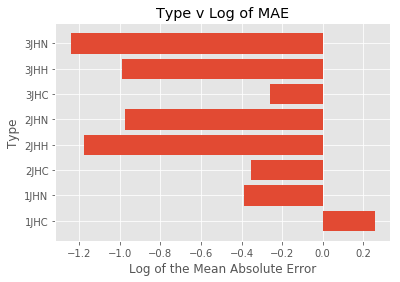

In [119]:
type_score = {}
plt.style.use('ggplot')
for i in range(len(test_scores)):
    type_score[J_type_list[i]] = test_scores[i]
  
plt.barh(list(type_score.keys()), list(type_score.values()))
plt.xlabel('Log of the Mean Absolute Error')
plt.ylabel('Type')
plt.title('Type v Log of MAE');

This plot gives an idea of validation score obtained by subtracting the test value from predicted value as log of MAE and the smaller, the better. The smallest is -1.27 by 3JHN type.

In [106]:
!pip install seaborn

In [107]:
import matplotlib as plt
import seaborn as sns
%matplotlib inline
# plt.figure(figsize=(10,10))


from matplotlib import *
import sys
from pylab import *

plt.Figure( figsize =(8,8) )


In [108]:
# https://www.datacamp.com/community/tutorials/seaborn-python-tutorial - for solving the scatterplot invocation error


# 16. Plotting target for all the coupling types togther

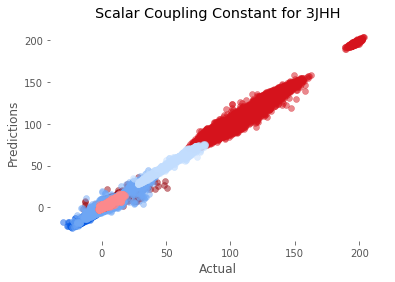

In [109]:
plots = [test_3JHH, test_3JHC, test_2JHH, test_1JHC, test_2JHC, test_3JHN, test_1JHN, test_2JHN]
colors = ['#0040cc', '#96040e',  '#075be6', '#D5131C', '#6fa7f5',  '#F23B41',   '#c2ddfe', '#FC8A8D']
names = ['1JHC', '1JHN', '2JHC', '2JHN', '2JHH', '3JHC', '3JHN', '3JHH']
for plot in plots:
  for cc in colors:
    for name in names:
      plt.scatter(plot['scalar_coupling_constant'], plot['preds'], marker='o',color=cc, alpha=.5)
      plt.xlabel('Actual')
      plt.ylabel('Predictions')
      plt.title(f'Scalar Coupling Constant for {name}')
      plt.grid(False)
      plt.box(False)
      plt.xlim(-40, 220)
      plt.ylim(-40, 220)
      plt.savefig(f'{name}.png', transparent=True)
      
      names.pop(0)
      break
      
    colors.pop(0)
    break
 

Inference: we can see that the predictions lie well within the range of actual valuesfor all the coupling types. This can be considered as accurate as predicted values are linearly related to the actual values.

# Scalar Coupling Constant VS Predictions after shuffling

In [110]:
test_final_shuffle = test_final.sample(frac=1, random_state=47)

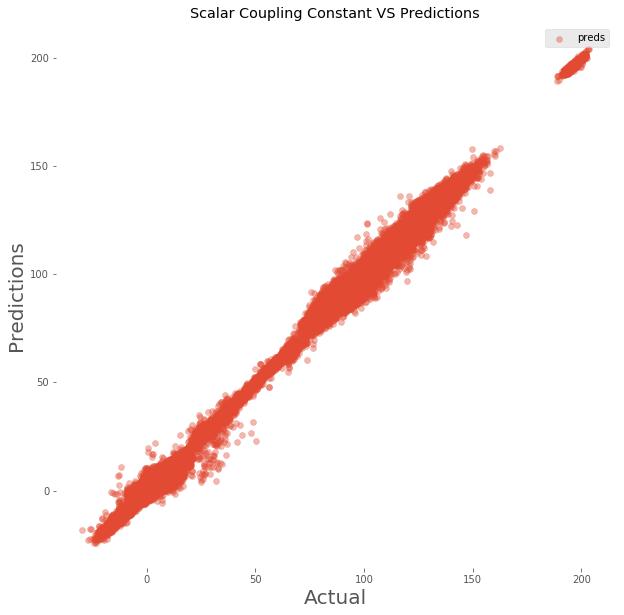

In [111]:
# palette = ['#86ACDE', '#5929E0', '#A4E6FC', '#E6090C', '#2765EB', '#1B04DB', '#911DE1', '#4353DF']
palette = ['#86ACDE', '#5929E0', '#A4E6FC']
plt.style.use('ggplot')
plt.figure(figsize=(10, 10))
plt.scatter(test_final_shuffle['scalar_coupling_constant'], test_final_shuffle['preds'],
                marker='o',
                alpha=.4)

plt.box(False)
plt.grid(False)
plt.xlabel('Actual', fontsize=20)
plt.ylabel('Predictions', fontsize=20)
plt.title('Scalar Coupling Constant VS Predictions')
plt.legend();

Inference:After shuffling we find that the correlation between actual and preducted is quite linear.

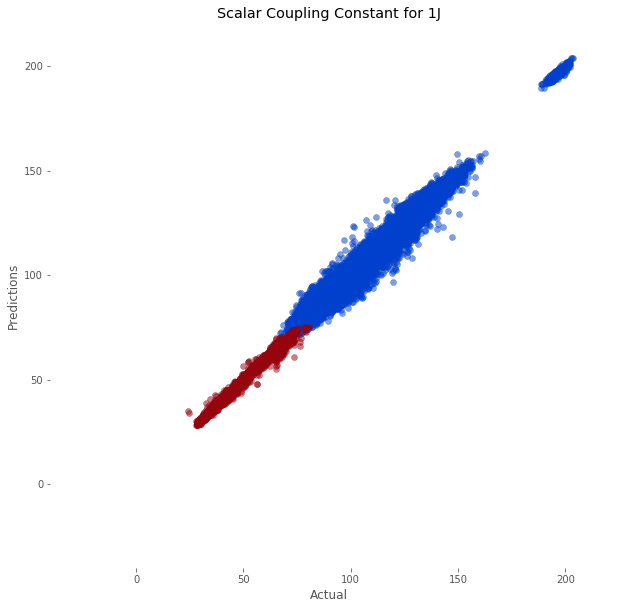

In [112]:
import seaborn as sns
plt.figure(figsize=(10, 10))
plots = [test_1JHC, test_1JHN]
colors = ['#0040cc', '#96040e']
names = ['1JHC', '1JHN']
for plot in plots:
  for cc in colors:
    for name in names:
      plt.scatter(plot['scalar_coupling_constant'], plot['preds'],
                      marker='o',
                      color=cc,
                      alpha=.5)
      plt.xlabel('Actual')
      plt.ylabel('Predictions')
      plt.title('Scalar Coupling Constant for 1J')
      plt.grid(False)
      plt.box(False)
      plt.xlim(-40, 220)
      plt.ylim(-40, 220)
      plt.savefig(f'{name}.png', transparent=True)
      
      names.pop(0)
      break
      
    colors.pop(0)
    break

This shows a linear correlation between the actual and predicted for 1j type coupling.

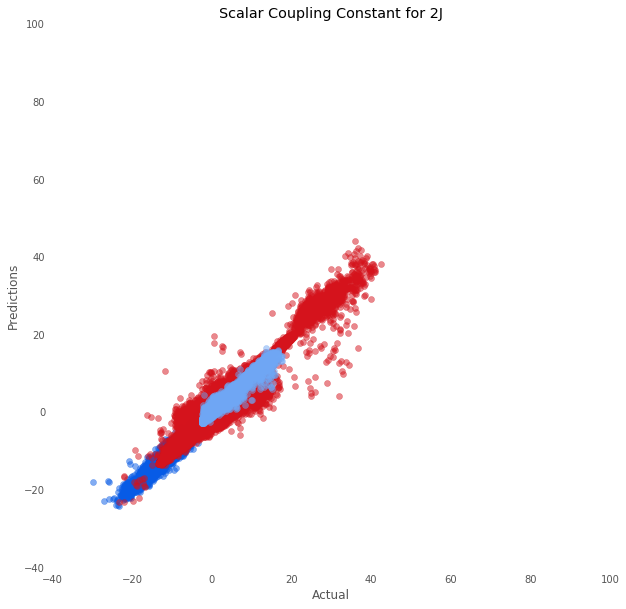

In [113]:
import seaborn as sns
plt.figure(figsize=(10, 10))
plots = [test_2JHH, test_2JHC, test_2JHN]
colors = ['#075be6', '#D5131C', '#6fa7f5']
names = ['2JHH', '2JHC', '2JHN']
for plot in plots:
  for cc in colors:
    for name in names:
      plt.scatter(plot['scalar_coupling_constant'], plot['preds'],
                      marker='o',
                      color=cc,
                      alpha=.5)
      plt.xlabel('Actual')
      plt.ylabel('Predictions')
      plt.title('Scalar Coupling Constant for 2J')
      plt.grid(False)
      plt.box(False)
      plt.xlim(-40, 100)
      plt.ylim(-40, 100)
      plt.tick_params(
              axis='x',          # changes apply to the x-axis
              which='both',      # both major and minor ticks are affected
              bottom=False,      # ticks along the bottom edge are off
              top=False,         # ticks along the top edge are off
              labelbottom=True) # labels along the bottom edge are off
      plt.tick_params(
              axis='y',          # changes apply to the x-axis
              which='both',      # both major and minor ticks are affected
              bottom=False,      # ticks along the bottom edge are off
              top=False,
              left=False,        # ticks along the top edge are off
              labelbottom=False) # labels along the bottom edge are off
      plt.savefig(f'{name}.png', transparent=True)
      
      names.pop(0)
      break
      
    colors.pop(0)
    break
 

This shows a linear correlation between the actual and predicted values for 2J type coupling.

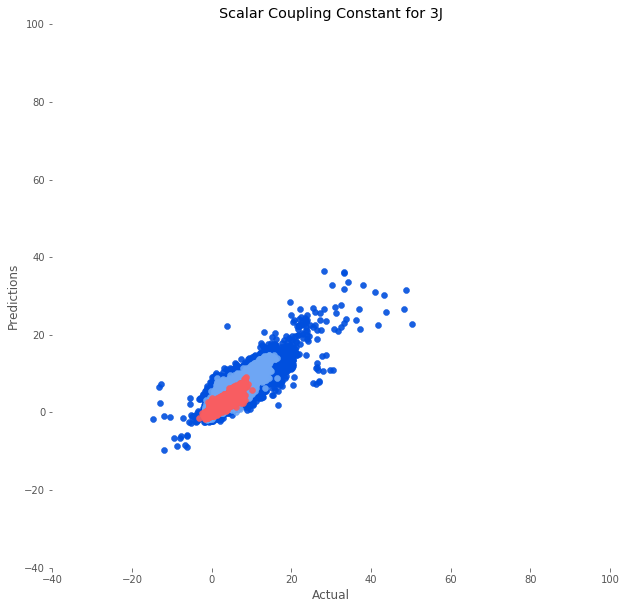

In [114]:
import seaborn as sns
plt.figure(figsize=(10, 10))
plots = [test_3JHC, test_3JHH, test_3JHN]
colors = ['#004fde', '#6fa7f5', '#F95D61']
names = ['3JHC', '3JHH', '3JHN']
for plot in plots:
  for cc in colors:
    for name in names:
      plt.scatter(plot['scalar_coupling_constant'], plot['preds'],
                      marker='o',
                      color=cc,
                      alpha=.9)
      plt.xlabel('Actual')
      plt.ylabel('Predictions')
      plt.title(f'Scalar Coupling Constant for 3J')
      plt.grid(False)
      plt.box(False)
      plt.xlim(-40, 100)
      plt.ylim(-40, 100)
      plt.savefig(f'{name}.png', transparent=True)
      
      names.pop(0)
      break
      
    colors.pop(0)
    break
 

This shows a linear correlation between the actual and predicted values for 3J type coupling.

# 17. Permutation Importance (importance of features) for each type is listed here. 
Here I am trying to study the effect of features on various types of coupling, using the weights. I want to check the hypothesis that the coupling types have varied effects of various features and want to confirm most useful features common for all. This might be helpful when it is required to design a better model.

In [115]:
import eli5
from eli5.sklearn import PermutationImportance

permuter_1JHC = PermutationImportance(clf_1JHC, scoring='neg_mean_squared_error', 
                                 cv='prefit', n_iter=2, random_state=42)

permuter_1JHC.fit(X_test_1JHC_encoded, y_test_1JHC)
feature_names_1JHC = X_test_1JHC_encoded.columns.tolist()
eli5.show_weights(permuter_1JHC, top=20, feature_names=feature_names_1JHC)

In [116]:
df_1JHC_imp = eli5.explain_weights_df(permuter_1JHC, top=None, feature_names=feature_names_1JHC)
df_1JHC_imp = df_1JHC_imp.drop('std', axis=1)
df_1JHC_imp.head()

feature     weight
0            n_bonds_y  50.589879
1             distance  40.363473
2  bond_lengths_mean_y  27.876447
3    mulliken_charge_1  17.098652
4    mulliken_charge_0  14.878380

In [182]:
permuter_1JHN = PermutationImportance(clf_1JHN, scoring='neg_mean_squared_error', 
                                 cv='prefit', n_iter=2, random_state=42)

permuter_1JHN.fit(X_test_1JHN_encoded, y_test_1JHN)
feature_names_1JHN = X_test_1JHN_encoded.columns.tolist()
eli5.show_weights(permuter_1JHN, top=None, feature_names=feature_names_1JHN)

In [183]:
df_1JHN_imp = eli5.explain_weights_df(permuter_1JHN, top=None, feature_names=feature_names_1JHN)
df_1JHN_imp = df_1JHN_imp.drop('std', axis=1)
df_1JHN_imp.head()

feature     weight
0  molecule_atom_index_1_dist_min  70.905075
1               mulliken_charge_0  26.169391
2             bond_lengths_mean_y  17.222150
3               mulliken_charge_1   5.195847
4                       n_bonds_y   1.292890

In [185]:
permuter_2JHH = PermutationImportance(clf_2JHH, scoring='neg_mean_squared_error', 
                                 cv='prefit', n_iter=2, random_state=42)

permuter_2JHH.fit(X_test_2JHH_encoded, y_test_2JHH)
feature_names_2JHH = X_test_2JHH_encoded.columns.tolist()
eli5.show_weights(permuter_2JHH, top=None, feature_names=feature_names_2JHH)

In [186]:
df_2JHH_imp = eli5.explain_weights_df(permuter_2JHH, top=None, feature_names=feature_names_2JHH)
df_2JHH_imp = df_2JHH_imp.drop('std', axis=1)
df_2JHH_imp.head()

feature    weight
0  molecule_atom_index_1_dist_min  4.936211
1                        distance  4.803075
2             bond_lengths_mean_y  3.907727
3               mulliken_charge_0  0.956112
4               mulliken_charge_1  0.898834

In [187]:
permuter_2JHC = PermutationImportance(clf_2JHC, scoring='neg_mean_squared_error', 
                                 cv='prefit', n_iter=2, random_state=42)

permuter_2JHC.fit(X_test_2JHC_encoded, y_test_2JHC)
feature_names_2JHC = X_test_2JHC_encoded.columns.tolist()
eli5.show_weights(permuter_2JHC, top=None, feature_names=feature_names_2JHC)

In [188]:
df_2JHC_imp = eli5.explain_weights_df(permuter_2JHC, top=None, feature_names=feature_names_2JHC)
df_2JHC_imp = df_2JHC_imp.drop('std', axis=1)
df_2JHC_imp.head()

feature    weight
0  molecule_atom_index_0_dist_min  4.886944
1             bond_lengths_mean_x  4.515842
2            atom_0_couples_count  3.147589
3               mulliken_charge_0  2.984394
4                        distance  2.255193

In [0]:
permuter_2JHN = PermutationImportance(clf_2JHN, scoring='neg_mean_squared_error', 
                                 cv='prefit', n_iter=2, random_state=42)

permuter_2JHN.fit(X_val_2JHN_encoded, y_val_2JHN)
feature_names_2JHN = X_val_2JHN_encoded.columns.tolist()
eli5.show_weights(permuter_2JHN, top=None, feature_names=feature_names_2JHN)

In [0]:
df_2JHN_imp = eli5.explain_weights_df(permuter_2JHN, top=None, feature_names=feature_names_2JHN)
df_2JHN_imp = df_2JHN_imp.drop('std', axis=1)
df_2JHN_imp.head()

feature    weight
0                       n_bonds_y  3.327019
1  molecule_atom_index_0_dist_min  2.278661
2             bond_lengths_mean_x  2.110305
3            atom_0_couples_count  1.502098
4             bond_lengths_mean_y  1.031995

In [0]:
permuter_3JHH = PermutationImportance(clf_3JHH, scoring='neg_mean_squared_error', 
                                 cv='prefit', n_iter=2, random_state=42)

permuter_3JHH.fit(X_val_3JHH_encoded, y_val_3JHH)
feature_names_3JHH = X_val_3JHH_encoded.columns.tolist()
eli5.show_weights(permuter_3JHH, top=None, feature_names=feature_names_3JHH)

In [0]:
df_3JHH_imp = eli5.explain_weights_df(permuter_3JHH, top=None, feature_names=feature_names_3JHH)
df_3JHH_imp = df_3JHH_imp.drop('std', axis=1)
df_3JHH_imp.head()

feature    weight
0    molecule_atom_1_dist_min_div  6.315368
1                        distance  5.004579
2             bond_lengths_mean_y  3.512802
3             bond_lengths_mean_x  1.518287
4  molecule_atom_index_1_dist_max  0.574139

In [0]:
permuter_3JHC = PermutationImportance(clf_3JHC, scoring='neg_mean_squared_error', 
                                 cv='prefit', n_iter=2, random_state=42)

permuter_3JHC.fit(X_val_3JHC_encoded, y_val_3JHC)
feature_names_3JHC = X_val_3JHC_encoded.columns.tolist()
eli5.show_weights(permuter_3JHC, top=None, feature_names=feature_names_3JHC)

In [0]:
df_3JHC_imp = eli5.explain_weights_df(permuter_3JHC, top=None, feature_names=feature_names_3JHC)
df_3JHC_imp = df_3JHC_imp.drop('std', axis=1)
df_3JHC_imp.head()

feature    weight
0                        distance  2.636834
1             bond_lengths_mean_y  1.336917
2             bond_lengths_mean_x  0.909996
3                       n_bonds_y  0.840672
4  molecule_atom_index_0_dist_min  0.733543

In [0]:
permuter_3JHN = PermutationImportance(clf_3JHN, scoring='neg_mean_squared_error', 
                                 cv='prefit', n_iter=2, random_state=42)

permuter_3JHN.fit(X_val_3JHN_encoded, y_val_3JHN)
feature_names_3JHN = X_val_3JHN_encoded.columns.tolist()
eli5.show_weights(permuter_3JHN, top=None, feature_names=feature_names_3JHN)

# Inference: The dataset was extremely limited in features, so the model relies heavily on engineering a lot of new features
1. Using data that included known molecular properties of molecules, I created machine learning models to predict the scalar coupling constant of a pair of atoms. 8 different LightGBM Regressor models were used to predict the target for each type of coupling: 1JHC, 1JHN, 2JHH, 2JHC, 2JHN, 3JHH, 3JHC, 3JHH, resulting in a final score of -0.64.
2. More than 50 features were engineered to help train the models accurately and improve the validation scores. Some features were very helpful for the models, some not so much, and the ones that did not impact the score at all were discarded. It was also found that over cluttering the data with bunch of features could also hurt the score, so a few of those features were removed as well.
3. The validation scores for each J coupling type were obtained and it was found that it varies with the type of coupling.The model predicting the 3JHN coupling constants performed the best with a validation score of -1.242, and the model predicting the 1JHC coupling constants performed the worst with a validation score of 0.258.
4. The significant differences in validation scores between models is due to features that are unaccounted for in our dataset that likely have a large effect on that specific type of coupling. To improve those scores further, some features we can try engineering are ones that take dipole interactions, magnetic shielding, and potential energy into account.
5. All of the models had different permutation importances depending on the type of coupling. Some of the most common features with high importance for each model were the distance, mulliken_charges, and both of the bond_lengths (x and y).
6. Here model is broken down by its respective validation score and permutation importances. 
7. Making use of the premutations and knowing about the best featuers impacting the scalar coupling constant using some more features MAE could br reduced further and model could be made more generalized.